
# Dissertation 
# Stock Price Prediction using different features and Machine Learining models

# Datasets, Models and Experiments in this sheet are as under,
 - DATASETS
     - Dataset_A - Historical stock price + Technical Indicators 
     - Dataset_B - Historical stock price + Technical Indicators + Financial Indicators/Ratios 
     - Dataset_C - Historical stock price + Technical Indicators + Financial Indicators/Ratios + Financial News NYT (word2vec)
     - Dataset_D1 - Historical stock price + Technical Indicators + Financial News NYT (word2vec)
     - Dataset_D2 - Historical stock price + Technical Indicators + Financial News NYT (FinBERT)
     - Dataset_D3 - Historical stock price + Technical Indicators + Financial News NYT (LLM-ChatGPT)
 - MODELS
     - LSTM
     - LSTM hyperparameter optimized
 - Experiments are as under, 
     - Experiment_1 - Dataset_A with Hyperparameter Optimized RF Regressor - - - - - - Output_1
     - Experiment_2 - Dataset_A with LSTM Model - - - - - - -  Output_2
     - Experiment_3 - Dataset_A with Hyperparameter Optimized LSTM Model - - - - - - -  Output_3
     -------
     - Experiment_4 - Dataset_B with LSTM Model - - - - - - -  Output_4
     - Experiment_5 - Dataset_B with Hyperparameter Optimized LSTM Model - - - - - - -  Output_5
     -------
     - Experiment_6 - Dataset_C with LSTM Model - - - - - - -  Output_6
     - Experiment_7 - Dataset_C with Hyperparameter Optimized LSTM Model - - - - - - -  Output_7
     -------
     - Experiment_8 - Dataset_D1 with LSTM Model - - - - - - -  Output_8
     - Experiment_9 - Dataset_D1 with Hyperparameter Optimized LSTM Model - - - - - - -  Output_9
     -------
     - Experiment_10 - Dataset_D2 with LSTM Model - - - - - - -  Output_10
     - Experiment_11 - Dataset_D2 with Hyperparameter Optimized LSTM Model - - - - - - -  Output_11
     -------
     - Experiment_12 - Dataset_D3 with LSTM Model - - - - - - -  Output_12
     - Experiment_13 - Dataset_D3 with Hyperparameter Optimized LSTM Model - - - - - - -  Output_13
     -------
 - Refer 2 more sheets for the complete work,
     - Sentiment Analysis sheet - for the analysis of three models in getting the sentiments for the NYT news articles 

Citation of codes:
LSTM Hyperparameter tunning codes citation - 

@misc{omalley2019kerastuner,
    title        = {KerasTuner},
    author       = {O'Malley, Tom and Bursztein, Elie and Long, James and Chollet, Fran\c{c}ois and Jin, Haifeng and Invernizzi, Luca and others},
    year         = 2019,
    howpublished = {\url{https://github.com/keras-team/keras-tuner}}
}

In [1]:
# PACKAGES INSTALLED

!pip install yfinance
!pip install TA-Lib
pip install optuna
pip install tensorflow
pip install numpy --upgrade
pip install keras-tuner

In [2]:
#PACKAGES USED 

#baisc
import numpy as np
import pandas as pd

#for pre-processing
#to load dataset & split
import yfinance as yf
from sklearn.model_selection import train_test_split
import talib

#for Data Transformation
from sklearn.preprocessing import MinMaxScaler

#for feature selection
#for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols

# for RF Regressor
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

#for LSTM Model
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#for LSTM Hyperparameter optimization
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

#performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

#for charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\deenu\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fundamental Historical stock price for last 10 years

In [4]:
# download the stock price
stock_name = "AAPL"
start_date = "2013-01-01"
end_date = "2023-08-01"
apple_ds = yf.download(stock_name, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [5]:
apple_ds = apple_ds.reset_index()

In [6]:
apple_ds

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791189,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579241,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022625,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200
...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400


In [7]:
apple_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2662 non-null   datetime64[ns]
 1   Open       2662 non-null   float64       
 2   High       2662 non-null   float64       
 3   Low        2662 non-null   float64       
 4   Close      2662 non-null   float64       
 5   Adj Close  2662 non-null   float64       
 6   Volume     2662 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 145.7 KB


In [8]:
apple_ds.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2662.000000,2662.000000,2662.000000,2662.000000,2662.000000,2.662000e+03
mean,67.925465,68.684493,67.213114,67.980810,66.032461,1.653939e+08
std,52.895419,53.548129,52.300525,52.956906,53.409300,1.242189e+08
min,13.856071,14.271429,13.753571,13.947500,12.013329,3.145820e+07
25%,27.309376,27.593750,27.086249,27.341250,25.022882,8.740400e+07
50%,43.128750,43.536249,42.804998,43.125000,41.108063,1.255824e+08
75%,121.650002,123.365002,120.055000,121.357500,119.586946,1.995775e+08
max,196.059998,198.229996,195.259995,196.449997,196.185074,1.460852e+09


In [9]:
rows_with_na1 = apple_ds[apple_ds.isna().any(axis=1)]
rows_with_na1

,Date,Open,High,Low,Close,Adj Close,Volume


In [10]:
apple_ds

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791189,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579241,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022625,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200
...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400


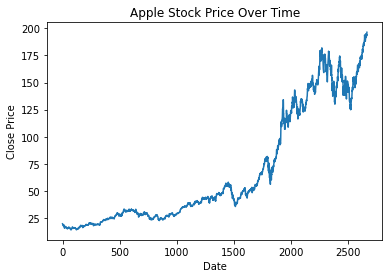

In [11]:
# Data Visualization
plt.plot(apple_ds.index, apple_ds['Close'])
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Apple Stock Price Over Time")
plt.show()

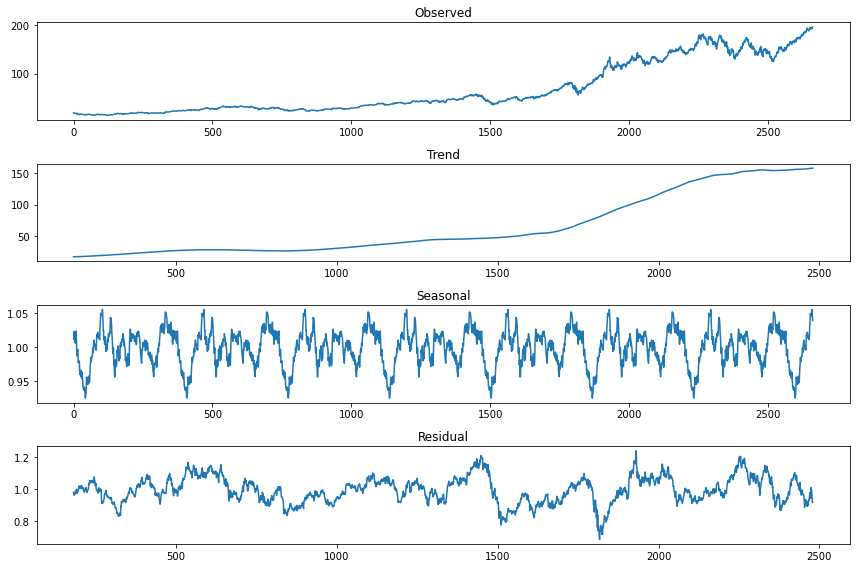

In [12]:
# decompose the close price data

from statsmodels.tsa.seasonal import seasonal_decompose

# 'Close' is the column we are focusing on
seasonal_decompose = seasonal_decompose(apple_ds['Close'], model='multiplicative', period=365)  # we can also use model='additive'

plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(seasonal_decompose.observed)
plt.title('Observed')
plt.subplot(4, 1, 2)
plt.plot(seasonal_decompose.trend)
plt.title('Trend')
plt.subplot(4, 1, 3)
plt.plot(seasonal_decompose.seasonal)
plt.title('Seasonal')
plt.subplot(4, 1, 4)
plt.plot(seasonal_decompose.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()


# Dataset_A 
Historical stock price + Technical Indicators

In [13]:
Dataset_A = apple_ds.copy()
Dataset_A

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791189,560518000
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579241,352965200
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022625,484156400
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200
...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400


In [14]:
# add technical indicators to the Dataset_A
# Technical indicators
Dataset_A['MACD'], Dataset_A['MACD_SIGNAL'], Dataset_A['MACD_HIST'] = talib.MACD(Dataset_A['Close'])
Dataset_A['ATR'] = talib.ATR(Dataset_A['High'], Dataset_A['Low'], Dataset_A['Close'])
Dataset_A['RSI'] = talib.RSI(Dataset_A['Close'])
Dataset_A['OBV'] = talib.OBV(Dataset_A['Close'], Dataset_A['Volume'])
Dataset_A['NATR'] = talib.NATR(Dataset_A['High'], Dataset_A['Low'], Dataset_A['Close'])
Dataset_A['ADXR'] = talib.ADXR(Dataset_A['High'], Dataset_A['Low'], Dataset_A['Close'])
Dataset_A['TRIX'] = talib.TRIX(Dataset_A['Close'])
Dataset_A['ADOSC'] = talib.ADOSC(Dataset_A['High'], Dataset_A['Low'], Dataset_A['Close'], Dataset_A['Volume'])
Dataset_A['AD'] = talib.AD(Dataset_A['High'], Dataset_A['Low'], Dataset_A['Close'], Dataset_A['Volume'])
Dataset_A['Stoch_SD'] = talib.STOCH(Dataset_A['High'], Dataset_A['Low'], Dataset_A['Close'])[1]
Dataset_A['MAX'] = Dataset_A['Close'].rolling(window=10).max()
Dataset_A['STD'] = Dataset_A['Close'].rolling(window=10).std()

Dataset_A

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,RSI,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD
0,2013-01-02,19.779285,19.821428,19.343929,19.608213,16.791189,560518000,NaN,NaN,NaN,...,NaN,5.605180e+08,NaN,NaN,NaN,NaN,5.994827e+07,NaN,NaN,NaN
1,2013-01-03,19.567142,19.631071,19.321428,19.360714,16.579241,352965200,NaN,NaN,NaN,...,NaN,2.075528e+08,NaN,NaN,NaN,NaN,-2.034526e+08,NaN,NaN,NaN
2,2013-01-04,19.177500,19.236786,18.779642,18.821428,16.117435,594333600,NaN,NaN,NaN,...,NaN,-3.867808e+08,NaN,NaN,NaN,NaN,-6.891336e+08,NaN,NaN,NaN
3,2013-01-07,18.642857,18.903570,18.400000,18.710714,16.022625,484156400,NaN,NaN,NaN,...,NaN,-8.709372e+08,NaN,NaN,NaN,NaN,-5.758185e+08,NaN,NaN,NaN
4,2013-01-08,18.900356,18.996071,18.616072,18.761070,16.065750,458707200,NaN,NaN,NaN,...,NaN,-4.122300e+08,NaN,NaN,NaN,NaN,-6.844624e+08,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200,2.657851,2.960267,-0.302416,...,62.777105,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900,2.647809,2.897775,-0.249967,...,64.613910,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200,2.507658,2.819752,-0.312094,...,59.977811,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400,2.577481,2.771298,-0.193817,...,65.425349,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057


In [15]:
#remove NaNs
rows_with_na2 = Dataset_A[Dataset_A.isna().any(axis=1)]
rows_with_na2

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na2.index

# Drop these rows with NaN
Dataset_A = Dataset_A.drop(indices_to_drop)
Dataset_A

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,RSI,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD
88,2013-05-09,16.421785,16.535713,16.270714,16.313213,14.143984,398487600,0.271312,0.062345,0.208967,...,61.742380,-4.615344e+09,2.463521,29.981111,-0.181239,2.620340e+08,-4.379399e+09,82.577853,16.565714,0.527265
89,2013-05-10,16.356071,16.418215,16.088572,16.177500,14.026318,334852000,0.275962,0.105068,0.170893,...,59.121052,-4.950196e+09,2.452293,30.092789,-0.169381,1.497200e+08,-4.533584e+09,70.571219,16.565714,0.379830
90,2013-05-13,16.125357,16.353571,16.125000,16.240713,14.081120,316948800,0.281502,0.140355,0.141147,...,59.973477,-4.633247e+09,2.368794,29.774748,-0.157250,9.142228e+07,-4.529625e+09,51.156178,16.565714,0.287066
91,2013-05-14,16.208929,16.257143,15.791071,15.852143,13.744226,447118000,0.251638,0.162612,0.089026,...,52.698973,-5.080365e+09,2.463520,28.879007,-0.145648,-4.571903e+07,-4.859566e+09,32.920279,16.565714,0.282085
92,2013-05-15,15.684286,15.750000,15.084286,15.316071,13.279432,741613600,0.182609,0.166611,0.015998,...,44.652128,-5.821978e+09,2.725721,28.078280,-0.135479,-1.693179e+08,-5.084757e+09,21.434176,16.565714,0.364639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200,2.657851,2.960267,-0.302416,...,62.777105,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900,2.647809,2.897775,-0.249967,...,64.613910,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200,2.507658,2.819752,-0.312094,...,59.977811,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400,2.577481,2.771298,-0.193817,...,65.425349,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057


Text(0.5, 1.0, 'STD')

<Figure size 432x288 with 0 Axes>

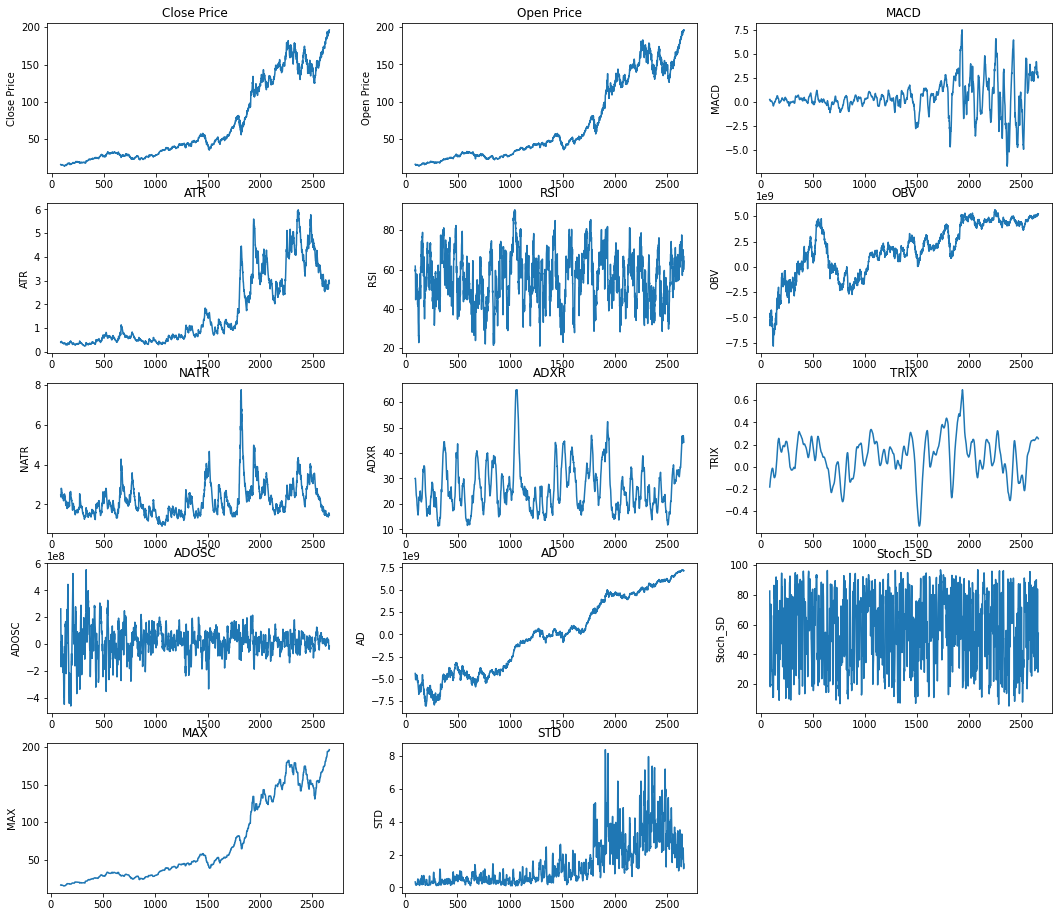

In [16]:
# Visvalize the Technical Indicators over 10 years
fig = plt.figure()
plt.figure(figsize=(18,16))
           
plt.subplot(5, 3, 1)
plt.plot(Dataset_A.Close)
plt.ylabel('Close Price')
plt.title('Close Price')
          
plt.subplot(5, 3, 2)
plt.plot(Dataset_A.Open)
plt.ylabel('Open Price')
plt.title('Open Price')

plt.subplot(5, 3, 3)
plt.plot(Dataset_A.MACD)
plt.ylabel('MACD')
plt.title('MACD')

plt.subplot(5, 3, 4)
plt.plot(Dataset_A.ATR)
plt.ylabel('ATR')
plt.title('ATR')

plt.subplot(5, 3, 5)
plt.plot(Dataset_A.RSI)
plt.ylabel('RSI')
plt.title('RSI')

plt.subplot(5, 3, 6)
plt.plot(Dataset_A.OBV)
plt.ylabel('OBV')
plt.title('OBV')

plt.subplot(5, 3, 7)
plt.plot(Dataset_A.NATR)
plt.ylabel('NATR')
plt.title('NATR')

Dataset_A['MAX'] = Dataset_A['Close'].rolling(window=10).max()
Dataset_A['STD'] = Dataset_A['Close'].rolling(window=10).std()

plt.subplot(5, 3, 8)
plt.plot(Dataset_A.ADXR)
plt.ylabel('ADXR')
plt.title('ADXR')

plt.subplot(5, 3, 9)
plt.plot(Dataset_A.TRIX)
plt.ylabel('TRIX')
plt.title('TRIX')

plt.subplot(5, 3, 10)
plt.plot(Dataset_A.ADOSC)
plt.ylabel('ADOSC')
plt.title('ADOSC')

plt.subplot(5, 3, 11)
plt.plot(Dataset_A.AD)
plt.ylabel('AD')
plt.title('AD')

plt.subplot(5, 3, 12)
plt.plot(Dataset_A.Stoch_SD)
plt.ylabel('Stoch_SD')
plt.title('Stoch_SD')

plt.subplot(5, 3, 13)
plt.plot(Dataset_A.MAX)
plt.ylabel('MAX')
plt.title('MAX')

plt.subplot(5, 3, 14)
plt.plot(Dataset_A.STD)
plt.ylabel('STD')
plt.title('STD')

# Experiment_1
Dataset_A with RF Regressor Model - - - - - - - Output_1

In [17]:
# pull Dataset_A
Dataset_A

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,RSI,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD
88,2013-05-09,16.421785,16.535713,16.270714,16.313213,14.143984,398487600,0.271312,0.062345,0.208967,...,61.742380,-4.615344e+09,2.463521,29.981111,-0.181239,2.620340e+08,-4.379399e+09,82.577853,NaN,NaN
89,2013-05-10,16.356071,16.418215,16.088572,16.177500,14.026318,334852000,0.275962,0.105068,0.170893,...,59.121052,-4.950196e+09,2.452293,30.092789,-0.169381,1.497200e+08,-4.533584e+09,70.571219,NaN,NaN
90,2013-05-13,16.125357,16.353571,16.125000,16.240713,14.081120,316948800,0.281502,0.140355,0.141147,...,59.973477,-4.633247e+09,2.368794,29.774748,-0.157250,9.142228e+07,-4.529625e+09,51.156178,NaN,NaN
91,2013-05-14,16.208929,16.257143,15.791071,15.852143,13.744226,447118000,0.251638,0.162612,0.089026,...,52.698973,-5.080365e+09,2.463520,28.879007,-0.145648,-4.571903e+07,-4.859566e+09,32.920279,NaN,NaN
92,2013-05-15,15.684286,15.750000,15.084286,15.316071,13.279432,741613600,0.182609,0.166611,0.015998,...,44.652128,-5.821978e+09,2.725721,28.078280,-0.135479,-1.693179e+08,-5.084757e+09,21.434176,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200,2.657851,2.960267,-0.302416,...,62.777105,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900,2.647809,2.897775,-0.249967,...,64.613910,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200,2.507658,2.819752,-0.312094,...,59.977811,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400,2.577481,2.771298,-0.193817,...,65.425349,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057


In [18]:
#remove NaNs
rows_with_na3 = Dataset_A[Dataset_A.isna().any(axis=1)]
rows_with_na3

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na3.index

# Drop these rows with NaN
Dataset_A = Dataset_A.drop(indices_to_drop)
Dataset_A

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,RSI,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD
97,2013-05-22,15.858929,16.012501,15.650714,15.762500,13.666499,443038400,0.085617,0.122217,-0.036601,...,51.702256,-5.208084e+09,2.726659,23.637740,-0.094809,-2.120751e+07,-4.802900e+09,60.137570,16.313213,0.338260
98,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200,0.082279,0.114230,-0.031951,...,52.174043,-4.855063e+09,2.694904,23.377643,-0.087777,-1.123016e+07,-4.723582e+09,68.797273,16.240713,0.290157
99,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800,0.087301,0.108844,-0.021543,...,54.017095,-4.578896e+09,2.570533,23.242826,-0.080859,6.483261e+07,-4.500564e+09,73.738997,16.240713,0.257723
100,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200,0.079672,0.103010,-0.023338,...,51.388442,-4.965041e+09,2.572999,22.894041,-0.074318,-1.867904e+07,-4.842301e+09,70.588906,15.898214,0.189405
101,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400,0.082786,0.098965,-0.016179,...,53.684818,-4.634465e+09,2.500397,22.536068,-0.067932,-1.218826e+07,-4.719866e+09,66.777089,15.898214,0.193463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200,2.657851,2.960267,-0.302416,...,62.777105,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900,2.647809,2.897775,-0.249967,...,64.613910,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200,2.507658,2.819752,-0.312094,...,59.977811,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400,2.577481,2.771298,-0.193817,...,65.425349,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057


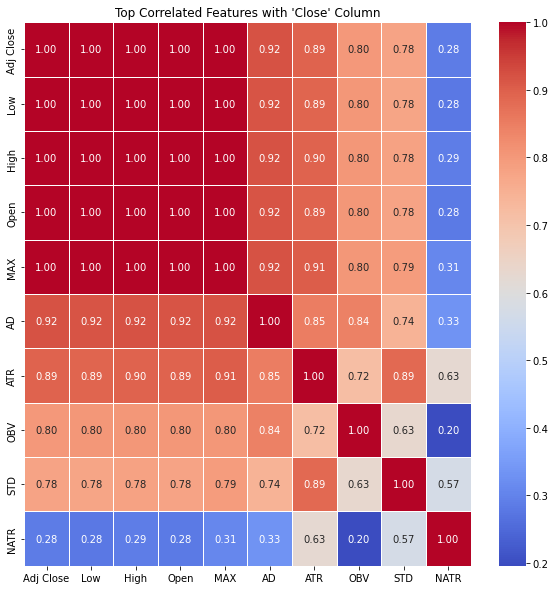

In [19]:
# Feature Selection:

correlation_matrix = Dataset_A.corr()

# Selecting top correlated features with the 'Close' column as an example target variable
top_correlated_features = correlation_matrix['Close'].sort_values(ascending=False).head(11).index[1:]

# Getting the top correlation values
top_corr_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

# Plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Top Correlated Features with 'Close' Column")
plt.show()

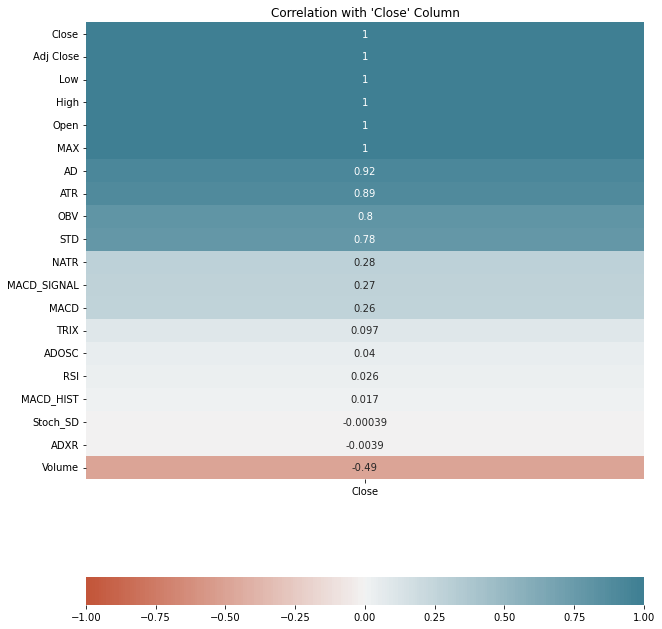

In [20]:
correlation_matrix = Dataset_A.corr()

# Extracting correlation of all features with the 'Close' column
close_corr = correlation_matrix[['Close']]

plt.figure(figsize=(10, 12))
ax = sns.heatmap(close_corr.sort_values(by='Close', ascending=False), 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True,
                 cbar_kws={"orientation": "horizontal"})

ax.set_title("Correlation with 'Close' Column")
plt.show()

In [21]:
# Dependent and independent variables  
x = Dataset_A.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
y = Dataset_A['Close']

#Split the data into training and temp datasets (80% train, 20% temp)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, shuffle=False)

# Adding a constant to the model (intercept)
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.797e+05
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:07:59   Log-Likelihood:                -4390.0
No. Observations:                2539   AIC:                             8808.
Df Residuals:                    2525   BIC:                             8890.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9690      0.339     -8.769      

In [22]:
# Train and Test split for modeling:

# Dependent and independent variables  
x = Dataset_A[['MAX', 'AD', 'ATR', 'OBV', 'STD']]
y = Dataset_A['Close']

# Split the data into training+validation (90%) and test dataset(10%)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Normalize the data

# Initialize the scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
x_train_val_sc = scaler_x.fit_transform(x_train_val)
x_test_sc = scaler_x.transform(x_test)

y_train_val_sc = scaler_y.fit_transform(y_train_val.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

In [23]:
#Model - these codes are refered from sklearn

def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 20, 200)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Initialize and fit the RandomForestRegressor model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=123,
    )
    
    # Perform cross-validation and compute the mean absolute error
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, x_train_val_sc, y_train_val_sc, cv=tscv, scoring='neg_mean_absolute_error')
    mae = -1 * scores.mean()
    
    return mae

In [24]:
study = optuna.create_study(direction='minimize')  # Minimize the mean absolute error
study.optimize(objective, n_trials=50)  # Number of trials


[I 2023-10-12 16:07:59,528] A new study created in memory with name: no-name-0fc2df0b-9c5d-49e2-9263-5b650bc694d3
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\a

[I 2023-10-12 16:08:03,698] Trial 4 finished with value: 0.07784272465150836 and parameters: {'n_estimators': 50, 'max_depth': 34, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.07758642731004645.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

[I 2023-10-12 16:08:10,088] Trial 9 finished with value: 0.0782366263608536 and parameters: {'n_estimators': 120, 'max_depth': 44, 'min_samples_split': 7, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.07758642731004645.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape

[I 2023-10-12 16:08:18,575] Trial 14 finished with value: 0.07763382580594258 and parameters: {'n_estimators': 197, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 9}. Best is trial 10 with value: 0.07744539678961845.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

[I 2023-10-12 16:08:26,947] Trial 19 finished with value: 0.07815187468743244 and parameters: {'n_estimators': 150, 'max_depth': 35, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 15 with value: 0.07743394571567541.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

[I 2023-10-12 16:08:33,648] Trial 24 finished with value: 0.07796681596992797 and parameters: {'n_estimators': 77, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 15 with value: 0.07743394571567541.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

[I 2023-10-12 16:08:43,512] Trial 29 finished with value: 0.07778704648477171 and parameters: {'n_estimators': 186, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 1}. Best is trial 25 with value: 0.07740806751061899.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[I 2023-10-12 16:08:51,632] Trial 34 finished with value: 0.07808388905356078 and parameters: {'n_estimators': 174, 'max_depth': 28, 'min_samples_split': 14, 'min_samples_leaf': 8}. Best is trial 25 with value: 0.07740806751061899.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[I 2023-10-12 16:08:58,028] Trial 39 finished with value: 0.07762766656664821 and parameters: {'n_estimators': 186, 'max_depth': 24, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 25 with value: 0.07740806751061899.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[I 2023-10-12 16:09:07,881] Trial 44 finished with value: 0.07763402225424244 and parameters: {'n_estimators': 153, 'max_depth': 34, 'min_samples_split': 15, 'min_samples_leaf': 9}. Best is trial 25 with value: 0.07740806751061899.
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\deenu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

[I 2023-10-12 16:09:17,067] Trial 49 finished with value: 0.0783096958542214 and parameters: {'n_estimators': 183, 'max_depth': 20, 'min_samples_split': 14, 'min_samples_leaf': 3}. Best is trial 45 with value: 0.0773850981951076.


In [25]:
# Best parameters
best_params = study.best_params
print(best_params)

# Train the final model with the best parameters
final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=123,
)
final_model.fit(x_train_val_sc, y_train_val_sc)

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\3078958111.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  final_model.fit(x_train_val_sc, y_train_val_sc)


{'n_estimators': 183, 'max_depth': 31, 'min_samples_split': 14, 'min_samples_leaf': 10}


RandomForestRegressor(max_depth=31, min_samples_leaf=10, min_samples_split=14,
                      n_estimators=183, random_state=123)

-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.03000478296582614
Mean Squared Error (MSE): 0.0016755037802931067
Mean Absolute Percentage Error (MAPE): 13.03358339092753%
-------------------performance metrics 2-----------------------------
predicted_values greater than upper_bound: 19
predicted_values lesser than lower_bound: 45
No. of predicted values within the ±5.0% interval: 193 / 257
Percentage of predictions within the ±5.0% interval: 75.10%


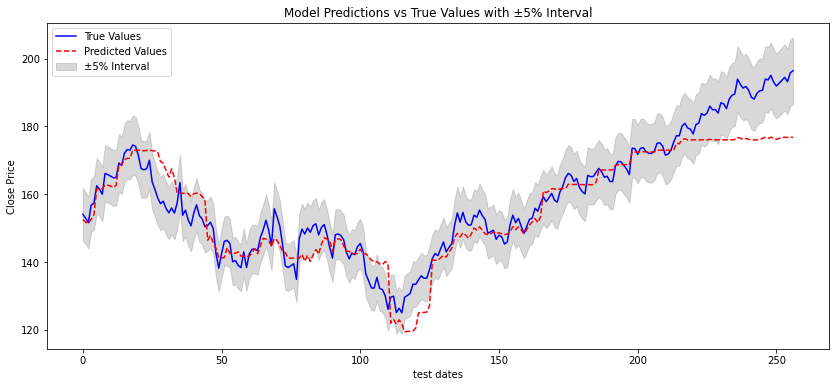

In [26]:
#predict with test data
predicted_values = final_model.predict(x_test_sc)

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
  
print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [27]:
#save output

output_df = pd.DataFrame(columns=['Experiment_Name', 'MAE', 'MSE', 'MAPE','Predicted > Upper Bound', 
                                   'Predicted < Lower Bound', 'Within Interval', 'Total Predictions', 
                                   'Percentage Within Interval'])
outputs = {
        'Experiment_Name': f"Experiment_1",
        'Experiment Description': f"Dataset_A with RF regressor Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\1886598823.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model


# Experiment_2
Dataset_A with LSTM Model - - - - - - - Output_2

In [28]:
# pull Dataset_A
Dataset_A

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,RSI,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD
97,2013-05-22,15.858929,16.012501,15.650714,15.762500,13.666499,443038400,0.085617,0.122217,-0.036601,...,51.702256,-5.208084e+09,2.726659,23.637740,-0.094809,-2.120751e+07,-4.802900e+09,60.137570,16.313213,0.338260
98,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200,0.082279,0.114230,-0.031951,...,52.174043,-4.855063e+09,2.694904,23.377643,-0.087777,-1.123016e+07,-4.723582e+09,68.797273,16.240713,0.290157
99,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800,0.087301,0.108844,-0.021543,...,54.017095,-4.578896e+09,2.570533,23.242826,-0.080859,6.483261e+07,-4.500564e+09,73.738997,16.240713,0.257723
100,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200,0.079672,0.103010,-0.023338,...,51.388442,-4.965041e+09,2.572999,22.894041,-0.074318,-1.867904e+07,-4.842301e+09,70.588906,15.898214,0.189405
101,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400,0.082786,0.098965,-0.016179,...,53.684818,-4.634465e+09,2.500397,22.536068,-0.067932,-1.218826e+07,-4.719866e+09,66.777089,15.898214,0.193463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200,2.657851,2.960267,-0.302416,...,62.777105,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900,2.647809,2.897775,-0.249967,...,64.613910,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200,2.507658,2.819752,-0.312094,...,59.977811,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400,2.577481,2.771298,-0.193817,...,65.425349,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057


In [29]:
#remove NaNs
rows_with_na3 = Dataset_A[Dataset_A.isna().any(axis=1)]
rows_with_na3

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na3.index

# Drop these rows with NaN
Dataset_A = Dataset_A.drop(indices_to_drop)
Dataset_A

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,RSI,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD
97,2013-05-22,15.858929,16.012501,15.650714,15.762500,13.666499,443038400,0.085617,0.122217,-0.036601,...,51.702256,-5.208084e+09,2.726659,23.637740,-0.094809,-2.120751e+07,-4.802900e+09,60.137570,16.313213,0.338260
98,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200,0.082279,0.114230,-0.031951,...,52.174043,-4.855063e+09,2.694904,23.377643,-0.087777,-1.123016e+07,-4.723582e+09,68.797273,16.240713,0.290157
99,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800,0.087301,0.108844,-0.021543,...,54.017095,-4.578896e+09,2.570533,23.242826,-0.080859,6.483261e+07,-4.500564e+09,73.738997,16.240713,0.257723
100,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200,0.079672,0.103010,-0.023338,...,51.388442,-4.965041e+09,2.572999,22.894041,-0.074318,-1.867904e+07,-4.842301e+09,70.588906,15.898214,0.189405
101,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400,0.082786,0.098965,-0.016179,...,53.684818,-4.634465e+09,2.500397,22.536068,-0.067932,-1.218826e+07,-4.719866e+09,66.777089,15.898214,0.193463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200,2.657851,2.960267,-0.302416,...,62.777105,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751
2658,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900,2.647809,2.897775,-0.249967,...,64.613910,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903
2659,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200,2.507658,2.819752,-0.312094,...,59.977811,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316
2660,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400,2.577481,2.771298,-0.193817,...,65.425349,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057


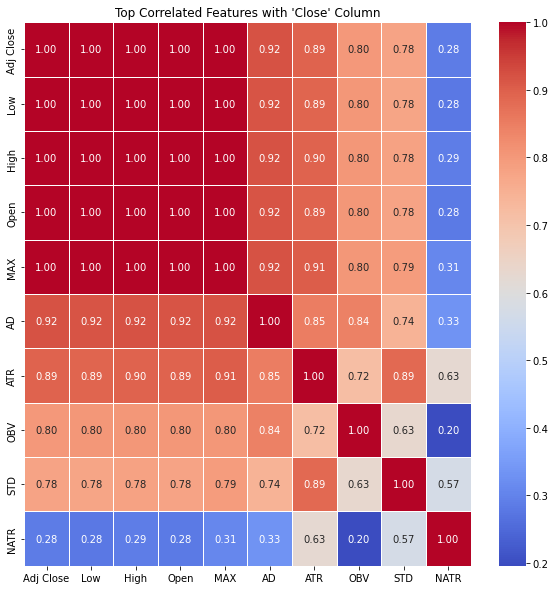

In [30]:
# Feature Selection:

correlation_matrix = Dataset_A.corr()

# Selecting top correlated features with the 'Close' column as an example target variable
top_correlated_features = correlation_matrix['Close'].sort_values(ascending=False).head(11).index[1:]

# Getting the top correlation values
top_corr_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

# Plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Top Correlated Features with 'Close' Column")
plt.show()

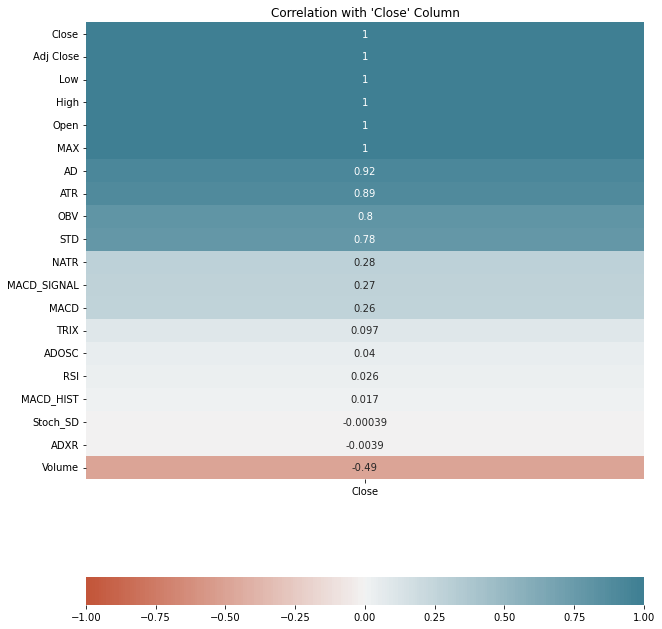

In [31]:
correlation_matrix = Dataset_A.corr()

# Extracting correlation of all features with the 'Close' column
close_corr = correlation_matrix[['Close']]

plt.figure(figsize=(10, 12))
ax = sns.heatmap(close_corr.sort_values(by='Close', ascending=False), 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True,
                 cbar_kws={"orientation": "horizontal"})

ax.set_title("Correlation with 'Close' Column")
plt.show()

In [32]:
# Dependent and independent variables  
x = Dataset_A.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
y = Dataset_A['Close']

#Split the data into training and temp datasets (80% train, 20% temp)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, shuffle=False)

# Adding a constant to the model (intercept)
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.797e+05
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:09:18   Log-Likelihood:                -4390.0
No. Observations:                2539   AIC:                             8808.
Df Residuals:                    2525   BIC:                             8890.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9690      0.339     -8.769      

In [33]:
# Train and Test split for modeling:

# Dependent and independent variables  
x = Dataset_A[['MAX', 'AD', 'ATR', 'OBV', 'STD']]
y = Dataset_A['Close']

# Split the data into training+validation and test datasets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size=0.1, shuffle=False)


In [34]:
# Model: the LSTM codes are refered from our letctures and lab, the timeseries code implementation from medium website. 

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

# Initialising the Expanding Window CV
tscv = TimeSeriesSplit(n_splits=5)

mae_list = []
mse_list = []
mape_list = []

# Looping through the train-test splits provided by expanding window
for train_index, test_index in tscv.split(X_train_val):
    
    x_train, x_test = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_test = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
    
    # Initialize the scaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both training and test data
    x_train_sc = scaler_x.fit_transform(x_train)
    x_test_sc = scaler_x.transform(x_test)

    y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Define the model
    model2 = Sequential()
    model2.add(LSTM(50, return_sequences=True, input_shape=(x_train_sc.shape[1], 1)))  # shape: (features, 1)
    model2.add(Dropout(0.1))
    model2.add(LSTM(50, return_sequences=False))
    model2.add(Dense(25))
    model2.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model2.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    # Train the model
    model_2 = model2.fit(x_train_sc, y_train_sc, epochs=20, batch_size=1, validation_data=(x_test_sc, y_test_sc), callbacks=[early_stopping])
    model2.summary()

    # Evaluate the model on the test dataset
    test_loss = model2.evaluate(x_test_sc, y_test_sc, verbose=1)
    print(f"Test Loss: {test_loss}")

    # Make predictions
    predicted_values = model2.predict(x_test_sc)

    #Performance Metrics 1:
    # Calculate Mean Absolute Error, Mean Squared Error,and MAPE
    mae = mean_absolute_error(y_test_sc, predicted_values)
    mse = mean_squared_error(y_test_sc, predicted_values)
    mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
    
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)

    print(f"-------------------performance metrics 1-----------------------------")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/20
388/388 [==============================] - 5s 8ms/step - loss: 0.0524 - val_loss: 0.0622
Epoch 2/20
388/388 [==============================] - 2s 6ms/step - loss: 0.0106 - val_loss: 0.0210
Epoch 3/20
388/388 [==============================] - 2s 6ms/step - loss: 0.0068 - val_loss: 0.0243
Epoch 4/20
388/388 [==============================] - 2s 6ms/step - loss: 0.0069 - val_loss: 0.0210
Epoch 5/20
388/388 [==============================] - 2s 6ms/step - loss: 0.0064 - val_loss: 0.0364
Epoch 6/20
388/388 [==============================] - 2s 6ms/step - loss: 0.0064 - val_loss: 0.0263
Epoch 7/20
388/388 [==============================] - 2s 6ms/step - loss: 0.0064 - val_loss: 0.0245
Epoch 7: early stopping
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 50)             10400     
                                                          

Epoch 6/20
1540/1540 [==============================] - 7s 5ms/step - loss: 0.0022 - val_loss: 0.1191
Epoch 7/20
1540/1540 [==============================] - 7s 5ms/step - loss: 0.0022 - val_loss: 0.2246
Epoch 7: early stopping
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 50)             10400     
                                                                 
 dropout_3 (Dropout)         (None, 5, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dense_7 (Dense)             (None, 1)                 26        
                        

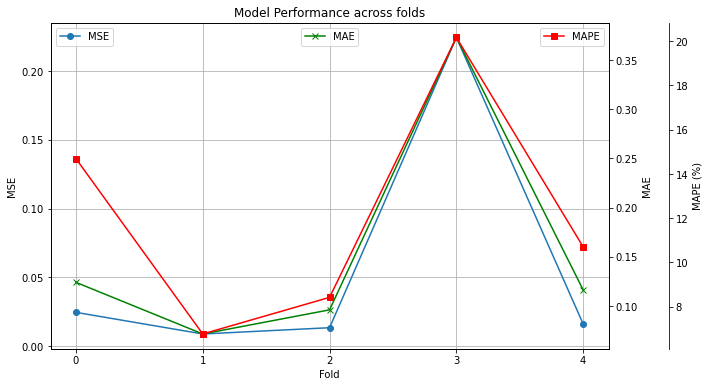

In [35]:
# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MSE values
ax1.plot(mse_list, marker='o', label='MSE')
ax1.set_title('Model Performance across folds')
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE')
ax1.grid(True)

# Setting the x-axis ticks with an interval of 1
ax1.set_xticks(range(len(mse_list)))

# Creating a second y-axis to plot MAE values
ax2 = ax1.twinx()
ax2.plot(mae_list, marker='x', color='g', label='MAE')
ax2.set_ylabel('MAE')

# Creating a third y-axis to plot MAPE values
ax3 = ax1.twinx()
# Offsetting the third y-axis 
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(mape_list, marker='s', color='r', label='MAPE')
ax3.set_ylabel('MAPE (%)')

# Adding a legend for each line
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')

plt.show()

9/9 [==============================] - 1s 3ms/step


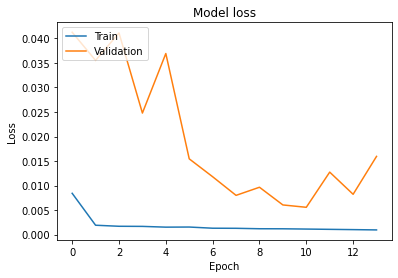

-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.08442648811823804
Mean Squared Error (MSE): 0.00902510144821026
Mean Absolute Percentage Error (MAPE): 6.885774531520503%
-------------------performance metrics 2-----------------------------
predicted_values greater than upper_bound: 0
predicted_values lesser than lower_bound: 169
No. of predicted values within the ±5.0% interval: 88 / 257
Percentage of predictions within the ±5.0% interval: 34.24%


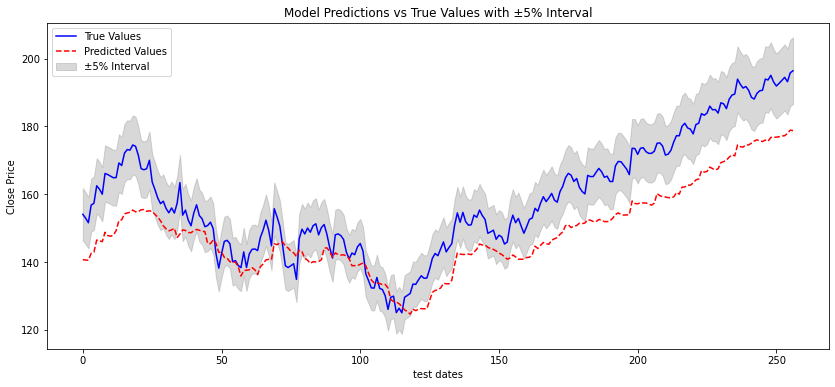

In [36]:
# transofrm the test data
X_test_sc = scaler_x.transform(X_test)
Y_test_sc = scaler_y.transform(Y_test.values.reshape(-1,1))

#predict with test data
predicted_values = model2.predict(X_test_sc)
y_test_sc = Y_test_sc

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(Y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

# Plot training & validation loss values
plt.plot(model_2.history['loss'])
plt.plot(model_2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
  
print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [37]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_2",
        'Experiment Description': f"Dataset_A with LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\843502470.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model


# Hyperparametert Tunning - Dataset_A

In [38]:
# Train and Test split for modeling:

# Dependent and independent variables  
x = Dataset_A[['MAX', 'AD', 'ATR', 'OBV', 'STD']]
y = Dataset_A['Close']

# Split the data into training+validation and test datasets (90% train and val, 10% test)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Normalize the data

# Initialize the scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
x_train_val_sc = scaler_x.fit_transform(x_train_val)
x_test_sc = scaler_x.transform(x_test)

y_train_val_sc = scaler_y.fit_transform(y_train_val.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

# Split the temp dataset into train and validation datasets (90% train, 10% val)
x_train_sc, x_val_sc, y_train_sc, y_val_sc = train_test_split(x_train_val_sc, y_train_val_sc, test_size=0.1, shuffle=False)

# Convert to numpy arrays
x_train_sc, y_train_sc = np.array(x_train_sc), np.array(y_train_sc)
x_val_sc, y_val_sc = np.array(x_val_sc), np.array(y_val_sc)
x_test_sc, y_test_sc = np.array(x_test_sc), np.array(y_test_sc)

# Get the last value from y_train_temp for later use
previous_values = y_train_sc[-1:]

In [39]:
# LSTM Hyperparameter optimization modeling

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

def build_model(hp):
    model3 = keras.Sequential()
    
    # Input layer
    model3.add(layers.Input(shape=(x_train_sc.shape[1], 1)))
    
    # Dynamically add LSTM layers based on hyperparameters
    for i in range(hp.Int('num_layers', 1, 2)):  # for demonstration, adjust as needed
        model3.add(layers.LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32), 
                              return_sequences=True))
        model3.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    
    model3.add(layers.LSTM(units=hp.Int('final_lstm_units', min_value=32, max_value=256, step=32), 
                          return_sequences=False))
    model3.add(layers.Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))

    model3.add(layers.Dense(1))

    # Define learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model3.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )

    return model3

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    verbose=1,
    mode='min'
)

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='dataset_A_LSTM_HP_exp_3'
)

tuner.search(
    x_train_sc, y_train_sc,
    epochs=20,
    validation_data=(x_val_sc, y_val_sc),
    callbacks=[early_stopping]
)

# Retrieve the best model and hyperparameters
best_model3 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters3 = tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

# Pull the summary of teh best model
best_model3.build(input_shape=(None, 28, 28))
best_model3.summary()

Trial 50 Complete [00h 00m 36s]
val_mean_squared_error: 0.21411967277526855

Best val_mean_squared_error So Far: 0.0012774678179994226
Total elapsed time: 00h 16m 41s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\dataset_A_LSTM_HP_exp_3
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 04 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 256
dropout_0: 0.4
final_lstm_units: 96
final_dropout: 0.0
learning_rate: 0.001
lstm_units_1: 160
dropout_1: 0.30000000000000004
Score: 0.0012774678179994226

Trial 40 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 256
dropout_0: 0.0
final_lstm_units: 128
final_dropout: 0.1
learning_rate: 0.001
lstm_units_1: 96
dropout_1: 0.1
Score: 0.0014899515081197023

Trial 44 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 192
dropout_0: 0.30000000000000004
final_lstm_units: 32
final_dropout: 0.30000000000000004
learning_rate: 0.001
lstm_units_1: 96
dropout_1: 0.30000000000000004
Score: 

# Experiment_3
Dataset_A with Hyperparameter Optimized best LSTM Model - - - - - - - Output_3

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 256)            264192    
                                                                 
 dropout (Dropout)           (None, 5, 256)            0         
                                                                 
 lstm_1 (LSTM)               (None, 96)                135552    
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 399841 (1.53 MB)
Trainable params: 399841 (1.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
9/9 [===============

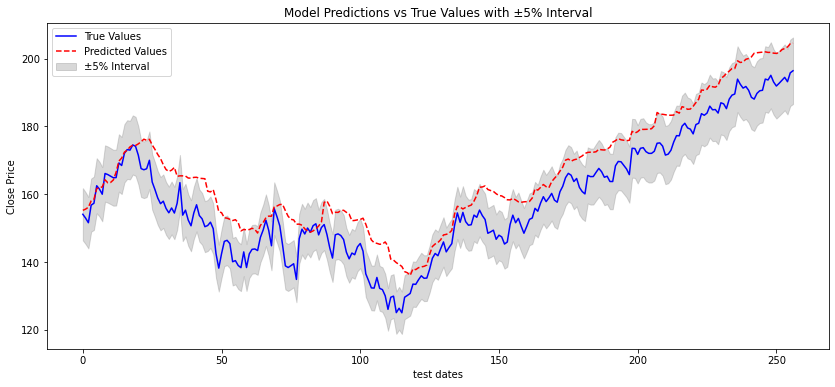

In [40]:
# Pull the summary of the best model
best_model3.build(input_shape=(None, 28, 28))
best_model3.summary()

# Predict the x_test with best model
predicted_values = best_model3.predict(x_test_sc)

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [41]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_3",
        'Experiment Description': f"Dataset_A with hyp-parameter optimixed LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\1554835350.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model


# Dataset_B
Historical stock price + Technical Indicators + Financial Indicators/Ratios

From yahoo finance we got only 4 years data and tried webscraping from 'macrotrends' where everything was consolidated into a table, but due to some security reasons we couldn.t scrap that. So, finally downloaded the financial statements from wise sheet and taken into python for manuipulation.

In [42]:
#Financialstatements for the last 10 years of Apple from Wise_Excel
# Read the Excel file
AAPL_fs = pd.read_excel('AAPL - financial statements.xlsx', sheet_name=None)

# Process each sheet
def process_sheet(df):
    # Drop the first three rows
    df = df.iloc[3:]
    # Drop rows where all values are NaN
    df = df.dropna(how='all')
    # Transpose the DataFrame
    df = df.transpose()
    # Set the first row as the column headers & drop the first row which is set as header
    df.columns = df.iloc[0]
    df = df.drop(df.index[0])
    # drop data more than 10 years
    df = df.drop(df.index[10:])
    return df

AAPL_is_df = process_sheet(AAPL_fs['AAPL - Income Statement FY'])
AAPL_bs_df = process_sheet(AAPL_fs['AAPL - Balance Sheet FY'])
AAPL_km_df = process_sheet(AAPL_fs['AAPL - Key Metrics FY'])

AAPL_is_df

Income Statement,Date,Revenue,Cost Of Revenue,Gross Profit,Gross Profit Ratio,Research And Development Expenses,Selling General And Administrative Expenses,General And Administrative Expenses,Selling And Marketing Expenses,Other Expenses,...,Total Other Income Expenses Net,Income Before Tax,Income Before Tax Ratio,Income Tax Expense,Net Income,Net Income Ratio,Eps,Epsdiluted,Weighted Average Shs Out,Weighted Average Shs Out Dil
Unnamed: 1,2022-09-30 00:00:00,394328000000,223546000000,170782000000,0.433096,26251000000,25094000000,0,0,-334000000,...,-334000000,119103000000,0.30204,19300000000,99803000000,0.253096,6.15,6.11,16215963000,16325819000
Unnamed: 2,2021-09-30 00:00:00,365817000000,212981000000,152836000000,0.417794,21914000000,21973000000,0,0,258000000,...,258000000,109207000000,0.298529,14527000000,94680000000,0.258818,5.67,5.61,16701272000,16864919000
Unnamed: 3,2020-09-30 00:00:00,274515000000,169559000000,104956000000,0.382332,18752000000,19916000000,0,0,803000000,...,803000000,67091000000,0.244398,9680000000,57411000000,0.209136,3.31,3.28,17352119000,17528214000
Unnamed: 4,2019-09-30 00:00:00,260174000000,161782000000,98392000000,0.378178,16217000000,18245000000,0,0,1807000000,...,1807000000,65737000000,0.252666,10481000000,55256000000,0.212381,2.99,2.97,18471336000,18595652000
Unnamed: 5,2018-09-28 00:00:00,265595000000,163756000000,101839000000,0.383437,14236000000,16705000000,0,0,2005000000,...,2005000000,72903000000,0.274489,13372000000,59531000000,0.224142,3,2.98,19821508000,20000436000
Unnamed: 6,2017-09-29 00:00:00,229234000000,141048000000,88186000000,0.384699,11581000000,15261000000,0,0,2745000000,...,2745000000,64089000000,0.279579,15738000000,48351000000,0.210924,2.32,2.3,20868968000,21006768000
Unnamed: 7,2016-09-30 00:00:00,215639000000,131376000000,84263000000,0.39076,10045000000,14194000000,0,0,1348000000,...,1348000000,61372000000,0.284605,15685000000,45687000000,0.211868,2.09,2.08,21883280000,22001124000
Unnamed: 8,2015-09-30 00:00:00,233715000000,140089000000,93626000000,0.400599,8067000000,14329000000,0,0,1285000000,...,1285000000,72515000000,0.310271,19121000000,53394000000,0.228458,2.32,2.31,23013684000,23172276000
Unnamed: 9,2014-09-30 00:00:00,182795000000,112258000000,70537000000,0.38588,6041000000,11993000000,0,0,-431000000,...,980000000,53483000000,0.292585,13973000000,39510000000,0.216144,1.62,1.61,24342288000,24490652000
Unnamed: 10,2013-09-30 00:00:00,170910000000,106606000000,64304000000,0.376245,4475000000,10830000000,0,0,1156000000,...,1156000000,50155000000,0.293459,13118000000,37037000000,0.216705,1.43,1.42,25909268000,26086536000


In [43]:
# Fetch the Financial Indicators/Ratios from the Financial Statements

# Create a new df for storing the Financial Indicators
AAPL_fi_df = pd.DataFrame()

AAPL_fi_df['Date'] = AAPL_km_df['Date']
AAPL_fi_df['P/E Ratio'] = AAPL_km_df['Pe Ratio']
AAPL_fi_df['P/B Ratio'] = AAPL_km_df['Pb Ratio']
AAPL_fi_df['Enterprise Value Over EBITDA'] = AAPL_km_df['Enterprise Value Over EBITDA']
AAPL_fi_df['ROA'] = AAPL_km_df['Return On Tangible Assets']
AAPL_fi_df['ROE'] = AAPL_km_df['Roe']

AAPL_fi_df['EPS'] = AAPL_is_df['Eps']
AAPL_fi_df['PEG'] = AAPL_fi_df['P/E Ratio'] / AAPL_fi_df['EPS']
AAPL_fi_df['ICR'] = AAPL_is_df['Operating Income'] / AAPL_is_df['Interest Expense']
AAPL_fi_df['Operating Margin(%)'] = (AAPL_is_df['Operating Income'] / AAPL_is_df['Revenue'])*100
AAPL_fi_df['Net Profit Ratio'] = (AAPL_is_df['Net Income'] / AAPL_is_df['Revenue'])


AAPL_fi_df['Debt-to-capital ratio'] = AAPL_bs_df['Total Debt'] / (AAPL_bs_df['Total Debt'] + AAPL_bs_df['Total Stockholders Equity'])
AAPL_fi_df['Quick Ratio'] = (AAPL_bs_df['Total Current Assets']-AAPL_bs_df['Inventory']) / AAPL_bs_df['Total Current Liabilities']

AAPL_fi_df

,Date,P/E Ratio,P/B Ratio,Enterprise Value Over EBITDA,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio
Unnamed: 1,2022-09-30 00:00:00,24.441824,48.14034,19.42524,0.282924,1.969589,6.15,3.97428,40.749574,30.288744,0.253096,0.703223,0.847235
Unnamed: 2,2021-09-30 00:00:00,25.916254,38.892865,21.155006,0.269742,1.500713,5.67,4.570768,41.190548,29.782378,0.258818,0.664074,1.022115
Unnamed: 3,2020-09-30 00:00:00,33.935934,29.81827,26.152202,0.177256,0.878664,3.31,10.252548,23.072746,24.147314,0.209136,0.632462,1.325072
Unnamed: 4,2019-09-30 00:00:00,18.288816,11.167965,13.988124,0.16323,0.610645,2.99,6.116661,17.877517,24.572017,0.212381,0.544221,1.501286
Unnamed: 5,2018-09-28 00:00:00,18.792325,10.441038,14.758938,0.162775,0.555601,3,6.264108,21.882099,26.694027,0.224142,0.51655,1.089992
Unnamed: 6,2017-09-29 00:00:00,16.630087,5.998503,12.579857,0.131638,0.360702,2.32,7.168141,26.407232,26.760428,0.210924,0.463226,1.227905
Unnamed: 7,2016-09-30 00:00:00,13.497731,4.808387,9.687062,0.145934,0.356237,2.09,6.458244,42.971841,29.014696,0.211868,0.404272,1.325684
Unnamed: 8,2015-09-30 00:00:00,12.361547,5.529994,8.527095,0.189697,0.447355,2.32,5.328253,97.175989,30.477291,0.228458,0.350686,1.07963
Unnamed: 9,2014-09-30 00:00:00,15.519672,5.497075,10.266986,0.177111,0.3542,1.62,9.580044,136.726562,28.722339,0.216144,0.24036,1.046842
Unnamed: 10,2013-09-30 00:00:00,12.060258,3.615373,8.059703,0.18404,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234


In [44]:
AAPL_fi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Unnamed: 1 to Unnamed: 10
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Date                          10 non-null     object
 1   P/E Ratio                     10 non-null     object
 2   P/B Ratio                     10 non-null     object
 3   Enterprise Value Over EBITDA  10 non-null     object
 4   ROA                           10 non-null     object
 5   ROE                           10 non-null     object
 6   EPS                           10 non-null     object
 7   PEG                           10 non-null     object
 8   ICR                           10 non-null     object
 9   Operating Margin(%)           10 non-null     object
 10  Net Profit Ratio              10 non-null     object
 11  Debt-to-capital ratio         10 non-null     object
 12  Quick Ratio                   10 non-null     object
dtypes: object

In [45]:
# Convert 'Date' column to datetime
AAPL_fi_df['Date'] = pd.to_datetime(AAPL_fi_df['Date'])

# Convert all other columns to float
for col in AAPL_fi_df.columns:
    if col != 'Date':
        AAPL_fi_df[col] = AAPL_fi_df[col].astype(float)
        
AAPL_fi_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Unnamed: 1 to Unnamed: 10
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          10 non-null     datetime64[ns]
 1   P/E Ratio                     10 non-null     float64       
 2   P/B Ratio                     10 non-null     float64       
 3   Enterprise Value Over EBITDA  10 non-null     float64       
 4   ROA                           10 non-null     float64       
 5   ROE                           10 non-null     float64       
 6   EPS                           10 non-null     float64       
 7   PEG                           10 non-null     float64       
 8   ICR                           10 non-null     float64       
 9   Operating Margin(%)           10 non-null     float64       
 10  Net Profit Ratio              10 non-null     float64       
 11  Debt-to-capital ratio

In [46]:
AAPL_fi_df

,Date,P/E Ratio,P/B Ratio,Enterprise Value Over EBITDA,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio
Unnamed: 1,2022-09-30,24.441824,48.140340,19.425240,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235
Unnamed: 2,2021-09-30,25.916254,38.892865,21.155006,0.269742,1.500713,5.67,4.570768,41.190548,29.782378,0.258818,0.664074,1.022115
Unnamed: 3,2020-09-30,33.935934,29.818270,26.152202,0.177256,0.878664,3.31,10.252548,23.072746,24.147314,0.209136,0.632462,1.325072
Unnamed: 4,2019-09-30,18.288816,11.167965,13.988124,0.163230,0.610645,2.99,6.116661,17.877517,24.572017,0.212381,0.544221,1.501286
Unnamed: 5,2018-09-28,18.792325,10.441038,14.758938,0.162775,0.555601,3.00,6.264108,21.882099,26.694027,0.224142,0.516550,1.089992
Unnamed: 6,2017-09-29,16.630087,5.998503,12.579857,0.131638,0.360702,2.32,7.168141,26.407232,26.760428,0.210924,0.463226,1.227905
Unnamed: 7,2016-09-30,13.497731,4.808387,9.687062,0.145934,0.356237,2.09,6.458244,42.971841,29.014696,0.211868,0.404272,1.325684
Unnamed: 8,2015-09-30,12.361547,5.529994,8.527095,0.189697,0.447355,2.32,5.328253,97.175989,30.477291,0.228458,0.350686,1.079630
Unnamed: 9,2014-09-30,15.519672,5.497075,10.266986,0.177111,0.354200,1.62,9.580044,136.726562,28.722339,0.216144,0.240360,1.046842
Unnamed: 10,2013-09-30,12.060258,3.615373,8.059703,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234


In [47]:
# Merge TI + FI 

apple_ds_b = Dataset_A.copy()
apple_ds_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 97 to 2661
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2565 non-null   datetime64[ns]
 1   Open         2565 non-null   float64       
 2   High         2565 non-null   float64       
 3   Low          2565 non-null   float64       
 4   Close        2565 non-null   float64       
 5   Adj Close    2565 non-null   float64       
 6   Volume       2565 non-null   int64         
 7   MACD         2565 non-null   float64       
 8   MACD_SIGNAL  2565 non-null   float64       
 9   MACD_HIST    2565 non-null   float64       
 10  ATR          2565 non-null   float64       
 11  RSI          2565 non-null   float64       
 12  OBV          2565 non-null   float64       
 13  NATR         2565 non-null   float64       
 14  ADXR         2565 non-null   float64       
 15  TRIX         2565 non-null   float64       
 16  ADOSC

In [48]:
tifi_merged_df = apple_ds_b.merge(AAPL_fi_df, on='Date', how='outer')
tifi_merged_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,Enterprise Value Over EBITDA,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio
0,2013-05-22,15.858929,16.012501,15.650714,15.762500,13.666499,443038400,0.085617,0.122217,-0.036601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200,0.082279,0.114230,-0.031951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800,0.087301,0.108844,-0.021543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200,0.079672,0.103010,-0.023338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400,0.082786,0.098965,-0.016179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#To check the merge 
#Create a list of 30th September dates for the past 10 years
dates = [f"{year}-09-30" for year in range(2013, 2023)]

# Filter merged_df using the isin function
filtered_df = tifi_merged_df[tifi_merged_df['Date'].isin(dates)]
filtered_df

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,Enterprise Value Over EBITDA,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio
90,2013-09-30,17.044643,17.202143,16.943214,17.026787,14.860144,260156400,0.015764,0.010176,0.005587,...,8.059703,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234
342,2014-09-30,25.202499,25.385000,25.132500,25.187500,22.478605,221056400,0.096834,0.157628,-0.060794,...,10.266986,0.177111,0.354200,1.62,9.580044,136.726562,28.722339,0.216144,0.240360,1.046842
594,2015-09-30,27.542500,27.885000,27.182501,27.575001,25.030014,265892000,-0.163720,-0.107400,-0.056321,...,8.527095,0.189697,0.447355,2.32,5.328253,97.175989,30.477291,0.228458,0.350686,1.079630
847,2016-09-30,28.115000,28.342501,27.950001,28.262501,26.202574,145516400,0.432027,0.458220,-0.026193,...,9.687062,0.145934,0.356237,2.09,6.458244,42.971841,29.014696,0.211868,0.404272,1.325684
1600,2019-09-30,55.224998,56.145000,55.197498,55.992500,54.458054,103909600,0.809002,0.850203,-0.041201,...,13.988124,0.163230,0.610645,2.99,6.116661,17.877517,24.572017,0.212381,0.544221,1.501286
1853,2020-09-30,113.790001,117.260002,113.620003,115.809998,113.753853,142675200,-0.664512,-0.646161,-0.018351,...,26.152202,0.177256,0.878664,3.31,10.252548,23.072746,24.147314,0.209136,0.632462,1.325072
2105,2021-09-30,143.660004,144.380005,141.279999,141.500000,139.881683,89056700,-1.654519,-0.834926,-0.819592,...,21.155006,0.269742,1.500713,5.67,4.570768,41.190548,29.782378,0.258818,0.664074,1.022115
2357,2022-09-30,141.279999,143.100006,138.000000,138.199997,137.384964,124925300,-4.154881,-2.829263,-1.325618,...,19.425240,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235


In [50]:
tifi_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2565 entries, 0 to 2564
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          2565 non-null   datetime64[ns]
 1   Open                          2565 non-null   float64       
 2   High                          2565 non-null   float64       
 3   Low                           2565 non-null   float64       
 4   Close                         2565 non-null   float64       
 5   Adj Close                     2565 non-null   float64       
 6   Volume                        2565 non-null   int64         
 7   MACD                          2565 non-null   float64       
 8   MACD_SIGNAL                   2565 non-null   float64       
 9   MACD_HIST                     2565 non-null   float64       
 10  ATR                           2565 non-null   float64       
 11  RSI                           

In [51]:
'''tifi_merged_df = tifi_merged_df.fillna(0)
tifi_merged_df'''

# Try with forward filling
tifi_merged_df = tifi_merged_df.fillna(method='ffill')
tifi_merged_df.iloc[50:100]



,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,Enterprise Value Over EBITDA,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio
50,2013-08-02,16.357500,16.530357,16.309286,16.519285,14.322656,274783600,0.307248,0.175551,0.131696,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,2013-08-05,16.596071,16.809643,16.505358,16.766071,14.536624,318855600,0.355058,0.211453,0.143606,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,2013-08-06,16.715000,16.853214,16.506071,16.616072,14.406570,334857600,0.376505,0.244463,0.132042,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,2013-08-07,16.564285,16.678572,16.491785,16.606428,14.398206,298858000,0.388248,0.273220,0.115028,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2013-08-08,16.566429,16.575001,16.355356,16.464643,14.369535,255777200,0.381713,0.294919,0.086794,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,2013-08-09,16.379999,16.445000,16.201786,16.230356,14.165058,266865200,0.353554,0.306646,0.046908,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,2013-08-12,16.316429,16.737499,16.308214,16.691429,14.567463,364434000,0.364243,0.318165,0.046078,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,2013-08-13,16.819286,17.666430,16.716070,17.484644,15.259743,881941200,0.431743,0.340881,0.090863,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,2013-08-14,17.781429,18.008928,17.621429,17.803572,15.538083,756372400,0.505150,0.373735,0.131415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,2013-08-15,17.729286,17.942858,17.467142,17.782499,15.519693,490294000,0.555224,0.410033,0.145192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
rows_with_na4 = tifi_merged_df[tifi_merged_df.isna().any(axis=1)]
rows_with_na4

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,Enterprise Value Over EBITDA,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio
0,2013-05-22,15.858929,16.012501,15.650714,15.762500,13.666499,443038400,0.085617,0.122217,-0.036601,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200,0.082279,0.114230,-0.031951,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800,0.087301,0.108844,-0.021543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200,0.079672,0.103010,-0.023338,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400,0.082786,0.098965,-0.016179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2013-09-23,17.717857,17.746786,17.235714,17.522858,15.293090,762106800,-0.060219,0.006654,-0.066873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,2013-09-24,17.674286,17.695356,17.422144,17.467857,15.245087,364344400,-0.016976,0.001928,-0.018904,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,2013-09-25,17.471430,17.487143,17.193930,17.197500,15.009136,316957200,-0.004469,0.000649,-0.005118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88,2013-09-26,17.357143,17.448570,17.282143,17.365000,15.155323,237221600,0.018742,0.004267,0.014475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# Identify indices of rows with NaN values
indices_to_drop = rows_with_na4.index

# Drop these rows with NaN
tifi_merged_df = tifi_merged_df.drop(indices_to_drop)
Dataset_B = tifi_merged_df

# Experiment_4
Dataset_B with LSTM Model - - - - - - - Output_4

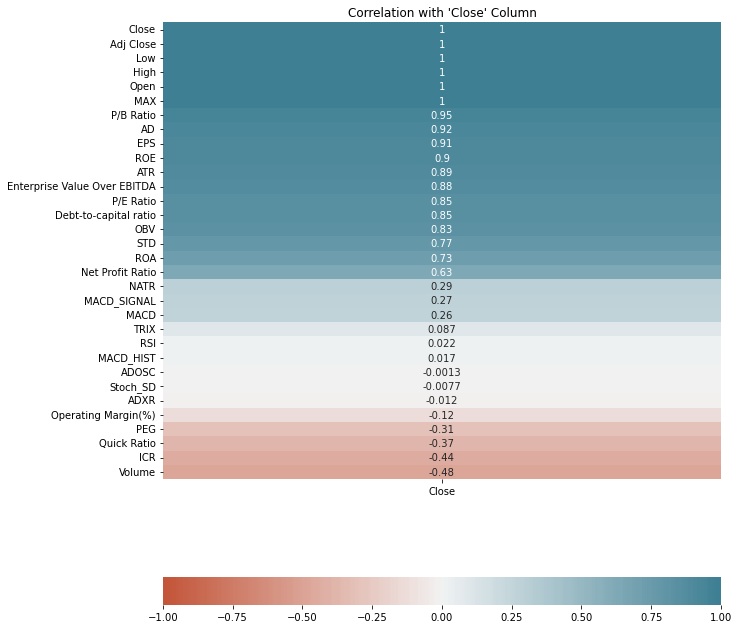

In [54]:
correlation_matrix = Dataset_B.corr()

# Extracting correlation of all features with the 'Close' column
close_corr = correlation_matrix[['Close']]

plt.figure(figsize=(10, 12))
ax = sns.heatmap(close_corr.sort_values(by='Close', ascending=False), 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True,
                 cbar_kws={"orientation": "horizontal"})

ax.set_title("Correlation with 'Close' Column")
plt.show()

In [55]:
# Dependent and independent variables  
x = Dataset_B.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)
y = Dataset_B['Close']

#Split the data into training and temp datasets (80% train, 20% temp)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, shuffle=False)

# Adding a constant to the model (intercept)
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.563e+05
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        16:31:42   Log-Likelihood:                -4255.0
No. Observations:                2450   AIC:                             8556.
Df Residuals:                    2427   BIC:                             8689.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

# NOTE: 
 - All the FI are with less correlation. 
 - This should be because of very less data points in FI. So try to predict the day after the release of financial statement. Is there an Impact of FI at that point?????
 - There is no point in testing the data with this features.
 - OK, Lets try a Forward Approach in filling the NaNs of Financial Indicators
 - After forward filling the FI correlations are higher, let us does it make any difference in the model. 

In [56]:
# TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_B[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'P/B Ratio', 'EPS', 'ROE', 'Enterprise Value Over EBITDA', 'P/E Ratio', 
               'Debt-to-capital ratio', 'ROA', 'Net Profit Ratio', 'ICR' ]]
y = Dataset_B['Close']

# Split the data into training+validation and test datasets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

In [57]:
# Model:

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

# Initialising the Expanding Window CV
tscv = TimeSeriesSplit(n_splits=5)

mae_list = []
mse_list = []
mape_list = []

# Looping through the train-test splits provided by expanding window
for train_index, test_index in tscv.split(X_train_val):
    
    x_train, x_test = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_test = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
    
    # Initialize the scaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both training and test data
    x_train_sc = scaler_x.fit_transform(x_train)
    x_test_sc = scaler_x.transform(x_test)

    y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Define the model
    model4 = Sequential()
    model4.add(LSTM(50, return_sequences=True, input_shape=(x_train_sc.shape[1], 1)))  # shape: (features, 1)
    model4.add(Dropout(0.1))
    model4.add(LSTM(50, return_sequences=False))
    model4.add(Dense(25))
    model4.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model4.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    # Train the model
    model_4 = model4.fit(x_train_sc, y_train_sc, epochs=20, batch_size=1, validation_data=(x_test_sc, y_test_sc), callbacks=[early_stopping])
    model4.summary()

    # Evaluate the model on the test dataset
    test_loss = model4.evaluate(x_test_sc, y_test_sc, verbose=1)
    print(f"Test Loss: {test_loss}")

    # Make predictions
    predicted_values = model4.predict(x_test_sc)

    #Performance Metrics 1:
    # Calculate Mean Absolute Error, Mean Squared Error,and MAPE
    mae = mean_absolute_error(y_test_sc, predicted_values)
    mse = mean_squared_error(y_test_sc, predicted_values)
    mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
    
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)

    print(f"-------------------performance metrics 1-----------------------------")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/20
372/372 [==============================] - 7s 12ms/step - loss: 0.0318 - val_loss: 0.1886
Epoch 2/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0135 - val_loss: 0.1100
Epoch 3/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0125 - val_loss: 0.0630
Epoch 4/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0112 - val_loss: 0.0417
Epoch 5/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0093 - val_loss: 0.0243
Epoch 6/20
372/372 [==============================] - 4s 11ms/step - loss: 0.0069 - val_loss: 0.0188
Epoch 7/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0059 - val_loss: 0.0143
Epoch 8/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0063 - val_loss: 0.0156
Epoch 9/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0060 - val_loss: 0.0378
Epoch 10/20
372/372 [==============================] - 4s 9ms/step - loss: 0.0053 - val_los

Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
12/12 [==============================] - 1s 6ms/step - loss: 1.3941
Test Loss: 1.3941272497177124
12/12 [==============================] - 1s 5ms/step
-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.8998476186966102
Mean Squared Error (MSE): 1.394127136551562
Mean Absolute Percentage Error (MAPE): 42.549147832079335%
Epoch 1/20
1856/1856 [==============================] - 17s 8ms/step - loss: 0.0060 - val_loss: 0.0380
Epoch 2/20
1856/1856 [==============================] - 14s 8ms/step - loss: 0.0025 - val_loss: 0.0447
Epoch 3/20
1856/1856 [==============================] - 14s 8ms/step - loss: 0.0022 - val_loss: 0.0469
Epoch 4/20
1856/1856 [==============================] - 14s 8ms/step - loss: 0.0020 - val_loss: 0.0868
Epoch 4: early stopping
Model: "sequential_5"
_________________________________________________________________
 Lay

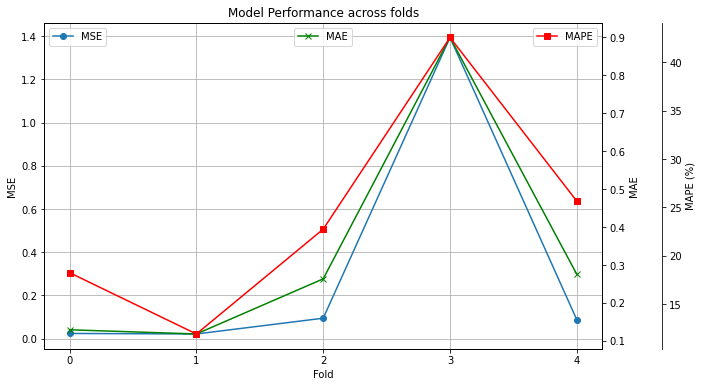

In [58]:
# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MSE values
ax1.plot(mse_list, marker='o', label='MSE')
ax1.set_title('Model Performance across folds')
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE')
ax1.grid(True)

# Setting the x-axis ticks with an interval of 1
ax1.set_xticks(range(len(mse_list)))

# Creating a second y-axis to plot MAE values
ax2 = ax1.twinx()
ax2.plot(mae_list, marker='x', color='g', label='MAE')
ax2.set_ylabel('MAE')

# Creating a third y-axis to plot MAPE values
ax3 = ax1.twinx()
# Offsetting the third y-axis 
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(mape_list, marker='s', color='r', label='MAPE')
ax3.set_ylabel('MAPE (%)')

# Adding a legend for each line
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')

plt.show()

8/8 [==============================] - 0s 6ms/step


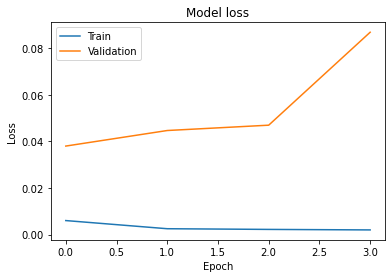

-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.2909076128719535
Mean Squared Error (MSE): 0.10397179246729135
Mean Absolute Percentage Error (MAPE): 24.7845353510109%
-------------------performance metrics 2-----------------------------
predicted_values greater than upper_bound: 0
predicted_values lesser than lower_bound: 244
No. of predicted values within the ±5.0% interval: 4 / 248
Percentage of predictions within the ±5.0% interval: 1.61%


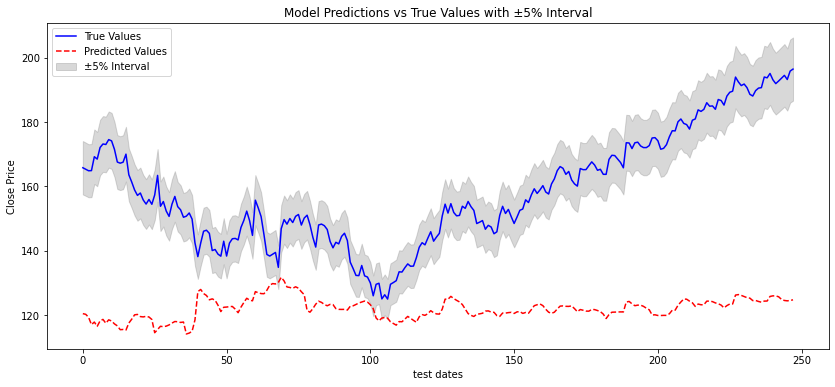

In [59]:
# transofrm the test data
X_test_sc = scaler_x.transform(X_test)
Y_test_sc = scaler_y.transform(Y_test.values.reshape(-1,1))

#predict with test data
predicted_values = model4.predict(X_test_sc)
y_test_sc = Y_test_sc

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(Y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))


# Plot training & validation loss values
plt.plot(model_4.history['loss'])
plt.plot(model_4.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    
print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [60]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_4",
        'Experiment Description': f"Dataset_B with LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\2285834916.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model


# Hyperparameter Tunning - Dataset_B

In [61]:
# TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_B[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'P/B Ratio', 'EPS', 'ROE', 'Enterprise Value Over EBITDA', 'P/E Ratio', 
               'Debt-to-capital ratio', 'ROA', 'Net Profit Ratio', 'ICR' ]]
y = Dataset_B['Close']

# Split the data into training+validation and test datasets (90% train and val, 10% test)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Normalize the data

# Initialize the scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
x_train_val_sc = scaler_x.fit_transform(x_train_val)
x_test_sc = scaler_x.transform(x_test)

y_train_val_sc = scaler_y.fit_transform(y_train_val.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

# Split the temp dataset into train and validation datasets (90% train, 10% val)
x_train_sc, x_val_sc, y_train_sc, y_val_sc = train_test_split(x_train_val_sc, y_train_val_sc, test_size=0.1, shuffle=False)

# Convert to numpy arrays
x_train_sc, y_train_sc = np.array(x_train_sc), np.array(y_train_sc)
x_val_sc, y_val_sc = np.array(x_val_sc), np.array(y_val_sc)
x_test_sc, y_test_sc = np.array(x_test_sc), np.array(y_test_sc)

# Get the last value from y_train_temp for later use
previous_values = y_train_sc[-1:]

In [62]:
# LSTM Hyperparameter optimization modeling

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

def build_model(hp):
    model5 = keras.Sequential()
    
    # Input layer
    model5.add(layers.Input(shape=(x_train_sc.shape[1], 1)))
    
    # Dynamically add LSTM layers based on hyperparameters
    for i in range(hp.Int('num_layers', 1, 2)):  # for demonstration, adjust as needed
        model5.add(layers.LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32), 
                              return_sequences=True))
        model5.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    
    model5.add(layers.LSTM(units=hp.Int('final_lstm_units', min_value=32, max_value=256, step=32), 
                          return_sequences=False))
    model5.add(layers.Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    model5.add(layers.Dense(1))

    # Define learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model5.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )

    return model5

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    verbose=1,
    mode='min'
)

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='dataset_B_LSTM_HP_exp_5'
)

tuner.search(
    x_train_sc, y_train_sc,
    epochs=20,
    validation_data=(x_val_sc, y_val_sc),
    callbacks=[early_stopping]
)

# Retrieve the best model and hyperparameters
best_model5 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters5 = tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

# Pull the summary of teh best model
best_model5.build(input_shape=(None, 28, 28))
best_model5.summary()

Trial 50 Complete [00h 01m 21s]
val_mean_squared_error: 0.005757685750722885

Best val_mean_squared_error So Far: 0.005639222916215658
Total elapsed time: 00h 26m 57s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\dataset_B_LSTM_HP_exp_5
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 06 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 96
dropout_0: 0.30000000000000004
final_lstm_units: 96
final_dropout: 0.1
learning_rate: 0.001
lstm_units_1: 160
dropout_1: 0.30000000000000004
Score: 0.005639222916215658

Trial 49 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 224
dropout_0: 0.1
final_lstm_units: 224
final_dropout: 0.1
learning_rate: 0.001
lstm_units_1: 192
dropout_1: 0.1
Score: 0.005757685750722885

Trial 45 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 192
dropout_0: 0.1
final_lstm_units: 32
final_dropout: 0.0
learning_rate: 0.0001
lstm_units_1: 256
dropout_1: 0.4
Score: 0.006027163937687874

Trial 38 s

# Experiment_5
Dataset_B with Hyperparameter Optimized best LSTM Model - - - - - - - Output_5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 96)            37632     
                                                                 
 dropout (Dropout)           (None, 14, 96)            0         
                                                                 
 lstm_1 (LSTM)               (None, 14, 160)           164480    
                                                                 
 dropout_1 (Dropout)         (None, 14, 160)           0         
                                                                 
 lstm_2 (LSTM)               (None, 96)                98688     
                                                                 
 dropout_2 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 9

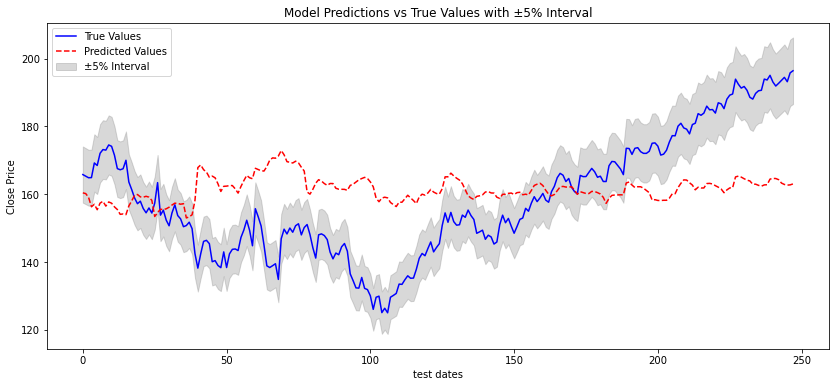

In [63]:
# Pull the summary of teh best model
best_model5.build(input_shape=(None, 28, 28))
best_model5.summary()

# Predict the x_test with best model
predicted_values = best_model5.predict(x_test_sc)

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [64]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_5",
        'Experiment Description': f"Dataset_B with hyp-parameter optimixed LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\1547269299.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model


# NOTE: 
 - The results are worser by forward filling the annual financial indicator.

# Dataset_C
Historical stock price + Technical Indicators + Financial Indicators/Ratios + Financial News NYT (word2vec)

In [65]:
#pulling data using pickle
import pickle

with open("fn_senti_wv.pkl", "rb") as file:
    fn_senti_wv = pickle.load(file)
fn_senti_wv

apple_ds_c = Dataset_B.copy()
apple_ds_c.info()

,Date,Dominant_Sentiment
0,2013-01-02,1.0
1,2013-01-03,0.0
2,2013-01-04,0.0
3,2013-01-07,1.0
4,2013-01-09,1.0
...,...,...
1469,2023-07-05,1.0
1470,2023-07-06,0.0
1471,2023-07-10,1.0
1472,2023-07-11,0.0


In [67]:
tififn_merged_df = apple_ds_c.merge(fn_senti_wv, on='Date', how='outer')
tififn_merged_df['Dominant_Sentiment'].fillna(method='ffill', inplace=True)
tififn_merged_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio,Dominant_Sentiment
0,2013-09-30,17.044643,17.202143,16.943214,17.026787,14.860144,260156400.0,0.015764,0.010176,0.005587,...,0.18404,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,1.0
1,2013-10-01,17.087500,17.469286,17.084999,17.427143,15.209558,353883600.0,0.038852,0.015912,0.022941,...,0.18404,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,1.0
2,2013-10-02,17.343929,17.564285,17.276787,17.484285,15.259429,289184000.0,0.061057,0.024941,0.036117,...,0.18404,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,-1.0
3,2013-10-03,17.518213,17.583929,17.169287,17.264643,15.067732,322753200.0,0.060237,0.032000,0.028237,...,0.18404,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,-1.0
4,2013-10-04,17.280714,17.307142,17.092857,17.251072,15.055889,258868400.0,0.057826,0.037165,0.020661,...,0.18404,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,0.0


In [68]:
rows_with_na7 = tififn_merged_df[tififn_merged_df.isna().any(axis=1)]
rows_with_na7

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio,Dominant_Sentiment
2475,2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2476,2013-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2477,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2478,2013-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2479,2013-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792,2023-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2793,2023-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2794,2023-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
2795,2023-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [69]:
# Identify indices of rows with NaN values
indices_to_drop = rows_with_na7.index

# Drop these rows with NaN
tififn_merged_df = tififn_merged_df.drop(indices_to_drop)
tififn_merged_df

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio,Dominant_Sentiment
0,2013-09-30,17.044643,17.202143,16.943214,17.026787,14.860144,260156400.0,0.015764,0.010176,0.005587,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,1.0
1,2013-10-01,17.087500,17.469286,17.084999,17.427143,15.209558,353883600.0,0.038852,0.015912,0.022941,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,1.0
2,2013-10-02,17.343929,17.564285,17.276787,17.484285,15.259429,289184000.0,0.061057,0.024941,0.036117,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,-1.0
3,2013-10-03,17.518213,17.583929,17.169287,17.264643,15.067732,322753200.0,0.060237,0.032000,0.028237,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,-1.0
4,2013-10-04,17.280714,17.307142,17.092857,17.251072,15.055889,258868400.0,0.057826,0.037165,0.020661,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200.0,2.657851,2.960267,-0.302416,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,0.0
2471,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900.0,2.647809,2.897775,-0.249967,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,0.0
2472,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200.0,2.507658,2.819752,-0.312094,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,1.0
2473,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400.0,2.577481,2.771298,-0.193817,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,1.0


In [70]:
Dataset_C = tififn_merged_df
Dataset_C

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,ROA,ROE,EPS,PEG,ICR,Operating Margin(%),Net Profit Ratio,Debt-to-capital ratio,Quick Ratio,Dominant_Sentiment
0,2013-09-30,17.044643,17.202143,16.943214,17.026787,14.860144,260156400.0,0.015764,0.010176,0.005587,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,1.0
1,2013-10-01,17.087500,17.469286,17.084999,17.427143,15.209558,353883600.0,0.038852,0.015912,0.022941,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,1.0
2,2013-10-02,17.343929,17.564285,17.276787,17.484285,15.259429,289184000.0,0.061057,0.024941,0.036117,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,-1.0
3,2013-10-03,17.518213,17.583929,17.169287,17.264643,15.067732,322753200.0,0.060237,0.032000,0.028237,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,-1.0
4,2013-10-04,17.280714,17.307142,17.092857,17.251072,15.055889,258868400.0,0.057826,0.037165,0.020661,...,0.184040,0.299776,1.43,8.433747,371.169118,29.535428,0.216705,0.120704,1.638234,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2470,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200.0,2.657851,2.960267,-0.302416,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,0.0
2471,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900.0,2.647809,2.897775,-0.249967,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,0.0
2472,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200.0,2.507658,2.819752,-0.312094,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,1.0
2473,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400.0,2.577481,2.771298,-0.193817,...,0.282924,1.969589,6.15,3.974280,40.749574,30.288744,0.253096,0.703223,0.847235,1.0


# Experiment_6
Dataset_C with LSTM Model - - - - - - - Output_6

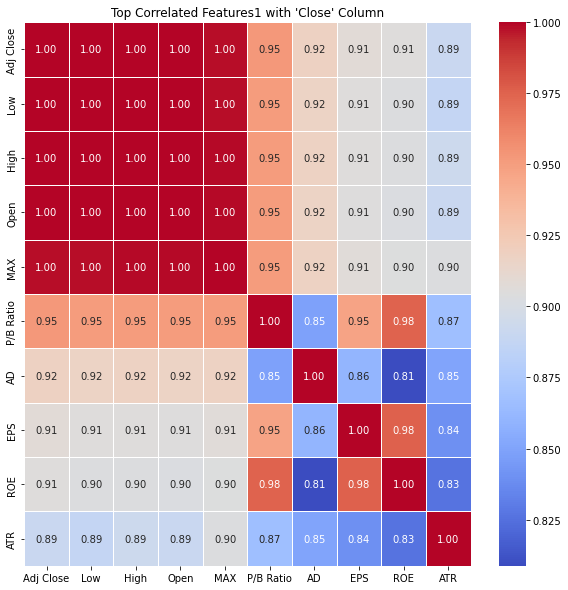

In [71]:
# Feature Selection for Dataset_D1

correlation_matrix = Dataset_C.corr()

# Selecting top correlated features with the 'Close' column as an example target variable
top_correlated_features = correlation_matrix['Close'].sort_values(ascending=False).head(11).index[1:]

# Getting the top correlation values
top_corr_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

# Plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Top Correlated Features1 with 'Close' Column")
plt.show()

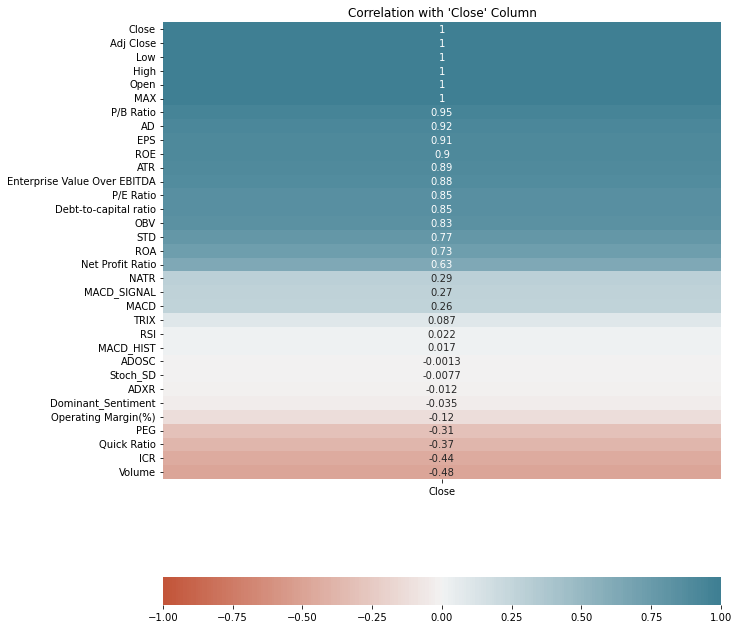

In [72]:
correlation_matrix = Dataset_C.corr()

# Extracting correlation of all features with the 'Close' column
close_corr = correlation_matrix[['Close']]

plt.figure(figsize=(10, 12))
ax = sns.heatmap(close_corr.sort_values(by='Close', ascending=False), 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True,
                 cbar_kws={"orientation": "horizontal"})

ax.set_title("Correlation with 'Close' Column")
plt.show()

In [73]:
# Dependent and independent variables  
x = Dataset_C.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dominant_Sentiment'], axis=1)
y = Dataset_C['Close']

#Split the data into training and temp datasets (80% train, 20% temp)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.01, shuffle=False)

# Adding a constant to the model (intercept)
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.563e+05
Date:                Thu, 12 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:03:03   Log-Likelihood:                -4255.0
No. Observations:                2450   AIC:                             8556.
Df Residuals:                    2427   BIC:                             8689.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [74]:
# ANOVA test to check if the means of the different levels of Dominant_Sentiment are significantly different in predicting the Close price

model = ols('Close ~ C(Dominant_Sentiment)', data=Dataset_C).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                             sum_sq      df         F    PR(>F)
C(Dominant_Sentiment)  3.979108e+04     2.0  7.145305  0.000805
Residual               6.883089e+06  2472.0       NaN       NaN


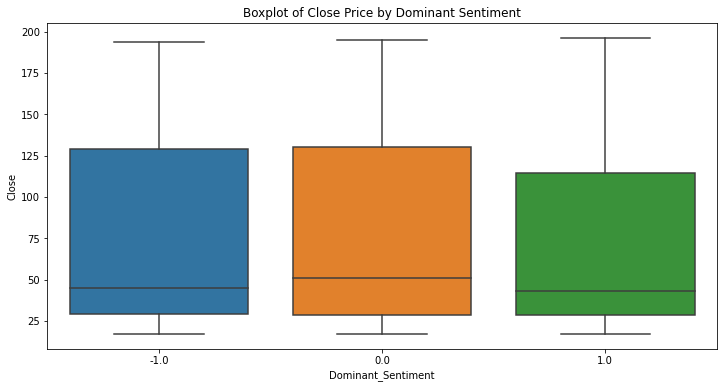

In [75]:
# Boxplot of Close Price by Dominant Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dominant_Sentiment', y='Close', data=Dataset_C)
plt.title('Boxplot of Close Price by Dominant Sentiment')
plt.show()

In [76]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_C[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'P/B Ratio', 'EPS', 'ROE', 'Enterprise Value Over EBITDA', 'P/E Ratio', 
               'Debt-to-capital ratio', 'ROA', 'Net Profit Ratio', 'ICR', 'Dominant_Sentiment']]
y = Dataset_C['Close']

# Split the data into training+validation and test datasets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size=0.1, shuffle=False)


In [77]:
# Model:

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

# Initialising the Expanding Window CV
tscv = TimeSeriesSplit(n_splits=5)

mae_list = []
mse_list = []
mape_list = []

# Looping through the train-test splits provided by expanding window
for train_index, test_index in tscv.split(X_train_val):
    
    x_train, x_test = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_test = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
    
    # Initialize the scaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both training and test data
    x_train_sc = scaler_x.fit_transform(x_train)
    x_test_sc = scaler_x.transform(x_test)

    y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Define the model
    model6 = Sequential()
    model6.add(LSTM(50, return_sequences=True, input_shape=(x_train_sc.shape[1], 1)))  # shape: (features, 1)
    model6.add(Dropout(0.1))
    model6.add(LSTM(50, return_sequences=False))
    model6.add(Dense(25))
    model6.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model6.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    # Train the model
    model_6 = model6.fit(x_train_sc, y_train_sc, epochs=20, batch_size=1, validation_data=(x_test_sc, y_test_sc), callbacks=[early_stopping])
    model6.summary()

    # Evaluate the model on the test dataset
    test_loss = model6.evaluate(x_test_sc, y_test_sc, verbose=1)
    print(f"Test Loss: {test_loss}")

    # Make predictions
    predicted_values = model6.predict(x_test_sc)

    #Performance Metrics 1:
    # Calculate Mean Absolute Error, Mean Squared Error,and MAPE
    mae = mean_absolute_error(y_test_sc, predicted_values)
    mse = mean_squared_error(y_test_sc, predicted_values)
    mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
    
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)

    print(f"-------------------performance metrics 1-----------------------------")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/20
372/372 [==============================] - 7s 12ms/step - loss: 0.0270 - val_loss: 0.2571
Epoch 2/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0132 - val_loss: 0.1606
Epoch 3/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0122 - val_loss: 0.0831
Epoch 4/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0110 - val_loss: 0.0540
Epoch 5/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0095 - val_loss: 0.0291
Epoch 6/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0073 - val_loss: 0.0218
Epoch 7/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0068 - val_loss: 0.0242
Epoch 8/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0067 - val_loss: 0.0183
Epoch 9/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0060 - val_loss: 0.0254
Epoch 10/20
372/372 [==============================] - 4s 10ms/step - loss: 0.0057 - val_lo

 lstm_10 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 25)                1275      
                                                                 
 dense_8 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
12/12 [==============================] - 1s 6ms/step - loss: 1.0603
Test Loss: 1.0603431463241577
12/12 [==============================] - 1s 6ms/step
-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.7700213363149797
Mean Squared Error (MSE): 1.060343269968673
Mean Absolute Percentage Error (MAPE): 35.74900427740866%
Epoch 1/20
1856/1856 [==============================] - 18s 8ms/s

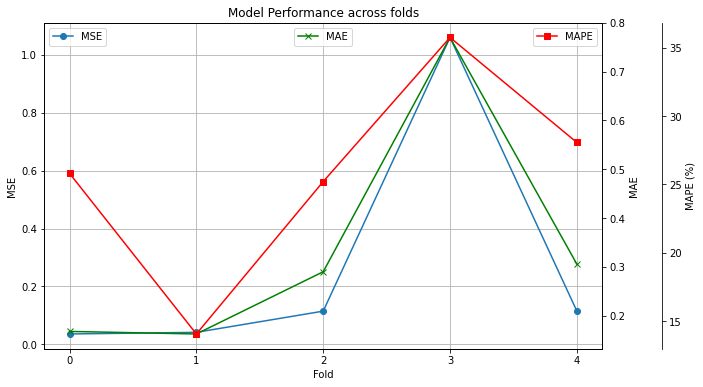

In [78]:
# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MSE values
ax1.plot(mse_list, marker='o', label='MSE')
ax1.set_title('Model Performance across folds')
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE')
ax1.grid(True)

# Setting the x-axis ticks with an interval of 1
ax1.set_xticks(range(len(mse_list)))

# Creating a second y-axis to plot MAE values
ax2 = ax1.twinx()
ax2.plot(mae_list, marker='x', color='g', label='MAE')
ax2.set_ylabel('MAE')

# Creating a third y-axis to plot MAPE values
ax3 = ax1.twinx()
# Offsetting the third y-axis 
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(mape_list, marker='s', color='r', label='MAPE')
ax3.set_ylabel('MAPE (%)')

# Adding a legend for each line
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')

plt.show()

8/8 [==============================] - 0s 7ms/step


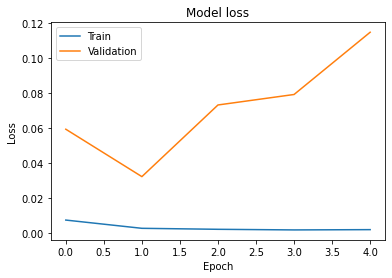

-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.4125556156483609
Mean Squared Error (MSE): 0.18824088174067669
Mean Absolute Percentage Error (MAPE): 35.823095251901485%
-------------------performance metrics 2-----------------------------
predicted_values greater than upper_bound: 0
predicted_values lesser than lower_bound: 248
No. of predicted values within the ±5.0% interval: 0 / 248
Percentage of predictions within the ±5.0% interval: 0.00%


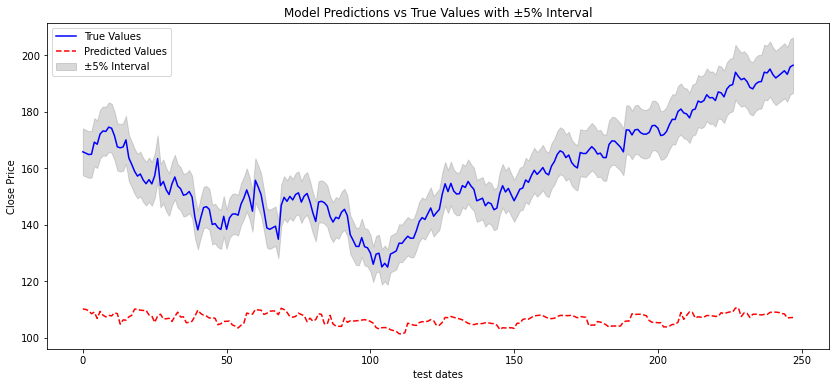

In [79]:
# transofrm the test data
X_test_sc = scaler_x.transform(X_test)
Y_test_sc = scaler_y.transform(Y_test.values.reshape(-1,1))

#predict with test data
predicted_values = model6.predict(X_test_sc)
y_test_sc = Y_test_sc

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(Y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

# Plot training & validation loss values
plt.plot(model_6.history['loss'])
plt.plot(model_6.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [80]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_6",
        'Experiment Description': f"Dataset_C with LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\4275849734.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model


# Hyperparameter Tunning - Dataset_C

In [81]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_C[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'P/B Ratio', 'EPS', 'ROE', 'Enterprise Value Over EBITDA', 'P/E Ratio', 
               'Debt-to-capital ratio', 'ROA', 'Net Profit Ratio', 'ICR', 'Dominant_Sentiment']]
y = Dataset_C['Close']

# Split the data into training+validation and test datasets (90% train and val, 10% test)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Normalize the data

# Initialize the scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
x_train_val_sc = scaler_x.fit_transform(x_train_val)
x_test_sc = scaler_x.transform(x_test)

y_train_val_sc = scaler_y.fit_transform(y_train_val.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

# Split the temp dataset into train and validation datasets (90% train, 10% val)
x_train_sc, x_val_sc, y_train_sc, y_val_sc = train_test_split(x_train_val_sc, y_train_val_sc, test_size=0.1, shuffle=False)

# Convert to numpy arrays
x_train_sc, y_train_sc = np.array(x_train_sc), np.array(y_train_sc)
x_val_sc, y_val_sc = np.array(x_val_sc), np.array(y_val_sc)
x_test_sc, y_test_sc = np.array(x_test_sc), np.array(y_test_sc)

# Get the last value from y_train_temp for later use
previous_values = y_train_sc[-1:]

In [82]:
# LSTM Hyperparameter optimization modeling

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

def build_model(hp):
    model7 = keras.Sequential()
    
    # Input layer
    model7.add(layers.Input(shape=(x_train_sc.shape[1], 1)))
    
    # Dynamically add LSTM layers based on hyperparameters
    for i in range(hp.Int('num_layers', 1, 2)):  # for demonstration, adjust as needed
        model7.add(layers.LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32), 
                              return_sequences=True))
        model7.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    
    model7.add(layers.LSTM(units=hp.Int('final_lstm_units', min_value=32, max_value=256, step=32), 
                          return_sequences=False))
    model7.add(layers.Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    model7.add(layers.Dense(1))

    # Define learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model7.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )

    return model7

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    verbose=1,
    mode='min'
)

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='dataset_C_LSTM_HP_exp_7'
)

tuner.search(
    x_train_sc, y_train_sc,
    epochs=20,
    validation_data=(x_val_sc, y_val_sc),
    callbacks=[early_stopping]
)

# Retrieve the best model and hyperparameters
best_model7 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters7 = tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

# Pull the summary of teh best model
best_model7.build(input_shape=(None, 28, 28))
best_model7.summary()

Trial 50 Complete [00h 00m 40s]
val_mean_squared_error: 0.21270467340946198

Best val_mean_squared_error So Far: 0.0012132853735238314
Total elapsed time: 00h 35m 24s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\dataset_C_LSTM_HP_exp_7
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 28 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 128
dropout_0: 0.0
final_lstm_units: 192
final_dropout: 0.1
learning_rate: 0.1
lstm_units_1: 96
dropout_1: 0.30000000000000004
Score: 0.0012132853735238314

Trial 32 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 256
dropout_0: 0.4
final_lstm_units: 224
final_dropout: 0.4
learning_rate: 0.1
lstm_units_1: 256
dropout_1: 0.1
Score: 0.0021626439411193132

Trial 29 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 192
dropout_0: 0.30000000000000004
final_lstm_units: 96
final_dropout: 0.30000000000000004
learning_rate: 0.001
lstm_units_1: 32
dropout_1: 0.2
Score: 0.00500027602538466

# Experiment_7
Dataset_C with Hyperparameter Optimized best LSTM Model - - - - - - - Output_7

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 15, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 192)               246528    
                                                                 
 dropout_1 (Dropout)         (None, 192)               0         
                                                                 
 dense (Dense)               (None, 1)                 193       
                                                                 
Total params: 313281 (1.20 MB)
Trainable params: 313281 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
8/8 [===============

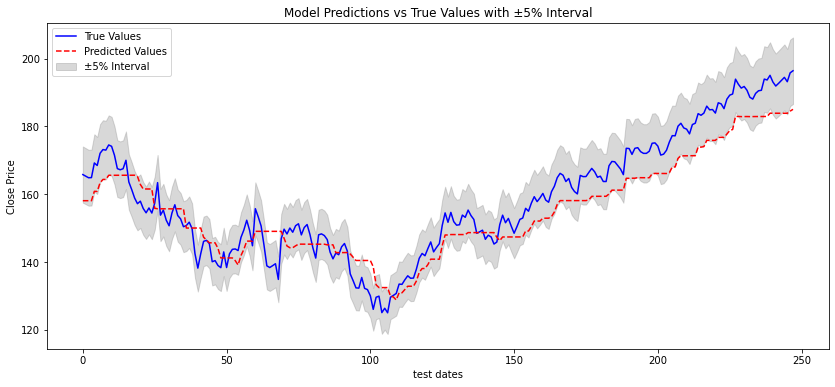

In [83]:
# Pull the summary of teh best model
best_model7.build(input_shape=(None, 28, 28))
best_model7.summary()

# Predict the x_test with best model
predicted_values = best_model7.predict(x_test_sc)

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [84]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_7",
        'Experiment Description': f"Dataset_C with hyp-parameter optimixed LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\3900834268.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model
6,Experiment_7,0.034891,0.001557,3.988539,18,34,196,248,79.032258,Dataset_C with hyp-parameter optimixed LSTM Model


# Dataset_D1
Historical stock price + Technical Indicators + Financial News NYT (word2vec)

In [85]:
#pulling data using pickle
import pickle

with open("fn_senti_wv.pkl", "rb") as file:
    fn_senti_wv = pickle.load(file)
fn_senti_wv

apple_ds_d1 = Dataset_A.copy()
apple_ds_d1.info()

#fill the NaNs of sentiments 
tifn_merged_df = apple_ds_d1.merge(fn_senti_wv, on='Date', how='outer')
tifn_merged_df['Dominant_Sentiment'].fillna(method='ffill', inplace=True)
tifn_merged_df.head()

rows_with_na7 = tifn_merged_df[tifn_merged_df.isna().any(axis=1)]
rows_with_na7

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na7.index

# Drop these rows with NaN
tifn_merged_df = tifn_merged_df.drop(indices_to_drop)
tifn_merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 97 to 2661
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2565 non-null   datetime64[ns]
 1   Open         2565 non-null   float64       
 2   High         2565 non-null   float64       
 3   Low          2565 non-null   float64       
 4   Close        2565 non-null   float64       
 5   Adj Close    2565 non-null   float64       
 6   Volume       2565 non-null   int64         
 7   MACD         2565 non-null   float64       
 8   MACD_SIGNAL  2565 non-null   float64       
 9   MACD_HIST    2565 non-null   float64       
 10  ATR          2565 non-null   float64       
 11  RSI          2565 non-null   float64       
 12  OBV          2565 non-null   float64       
 13  NATR         2565 non-null   float64       
 14  ADXR         2565 non-null   float64       
 15  TRIX         2565 non-null   float64       
 16  ADOSC

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD,Dominant_Sentiment
1,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200.0,0.082279,0.114230,-0.031951,...,-4.855063e+09,2.694904,23.377643,-0.087777,-1.123016e+07,-4.723582e+09,68.797273,16.240713,0.290157,0.0
2,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800.0,0.087301,0.108844,-0.021543,...,-4.578896e+09,2.570533,23.242826,-0.080859,6.483261e+07,-4.500564e+09,73.738997,16.240713,0.257723,1.0
3,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200.0,0.079672,0.103010,-0.023338,...,-4.965041e+09,2.572999,22.894041,-0.074318,-1.867904e+07,-4.842301e+09,70.588906,15.898214,0.189405,1.0
4,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400.0,0.082786,0.098965,-0.016179,...,-4.634465e+09,2.500397,22.536068,-0.067932,-1.218826e+07,-4.719866e+09,66.777089,15.898214,0.193463,0.0
5,2013-05-30,15.916071,16.232143,15.875357,16.127857,13.983276,353519600.0,0.103172,0.099806,0.003366,...,-4.280945e+09,2.445726,22.181210,-0.061328,3.830235e+07,-4.573009e+09,62.591568,16.127857,0.187501,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200.0,2.657851,2.960267,-0.302416,...,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751,0.0
2561,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900.0,2.647809,2.897775,-0.249967,...,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903,0.0
2562,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200.0,2.507658,2.819752,-0.312094,...,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316,1.0
2563,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400.0,2.577481,2.771298,-0.193817,...,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057,1.0


In [86]:
Dataset_D1 = tifn_merged_df
Dataset_D1

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD,Dominant_Sentiment
1,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200.0,0.082279,0.114230,-0.031951,...,-4.855063e+09,2.694904,23.377643,-0.087777,-1.123016e+07,-4.723582e+09,68.797273,16.240713,0.290157,0.0
2,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800.0,0.087301,0.108844,-0.021543,...,-4.578896e+09,2.570533,23.242826,-0.080859,6.483261e+07,-4.500564e+09,73.738997,16.240713,0.257723,1.0
3,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200.0,0.079672,0.103010,-0.023338,...,-4.965041e+09,2.572999,22.894041,-0.074318,-1.867904e+07,-4.842301e+09,70.588906,15.898214,0.189405,1.0
4,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400.0,0.082786,0.098965,-0.016179,...,-4.634465e+09,2.500397,22.536068,-0.067932,-1.218826e+07,-4.719866e+09,66.777089,15.898214,0.193463,0.0
5,2013-05-30,15.916071,16.232143,15.875357,16.127857,13.983276,353519600.0,0.103172,0.099806,0.003366,...,-4.280945e+09,2.445726,22.181210,-0.061328,3.830235e+07,-4.573009e+09,62.591568,16.127857,0.187501,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200.0,2.657851,2.960267,-0.302416,...,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751,0.0
2561,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900.0,2.647809,2.897775,-0.249967,...,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903,0.0
2562,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200.0,2.507658,2.819752,-0.312094,...,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316,1.0
2563,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400.0,2.577481,2.771298,-0.193817,...,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057,1.0


# Experiment_8
Dataset_D1 with LSTM Model - - - - - - - Output_8

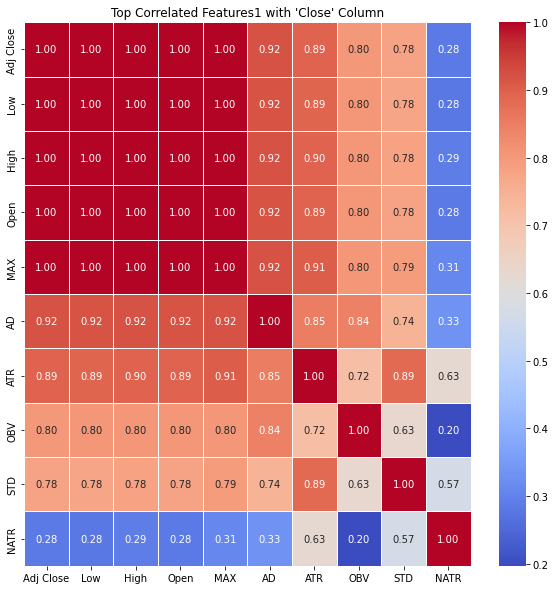

In [87]:
# Feature Selection for Dataset_D1

correlation_matrix = Dataset_D1.corr()

# Selecting top correlated features with the 'Close' column as an example target variable
top_correlated_features = correlation_matrix['Close'].sort_values(ascending=False).head(11).index[1:]

# Getting the top correlation values
top_corr_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

# Plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Top Correlated Features1 with 'Close' Column")
plt.show()

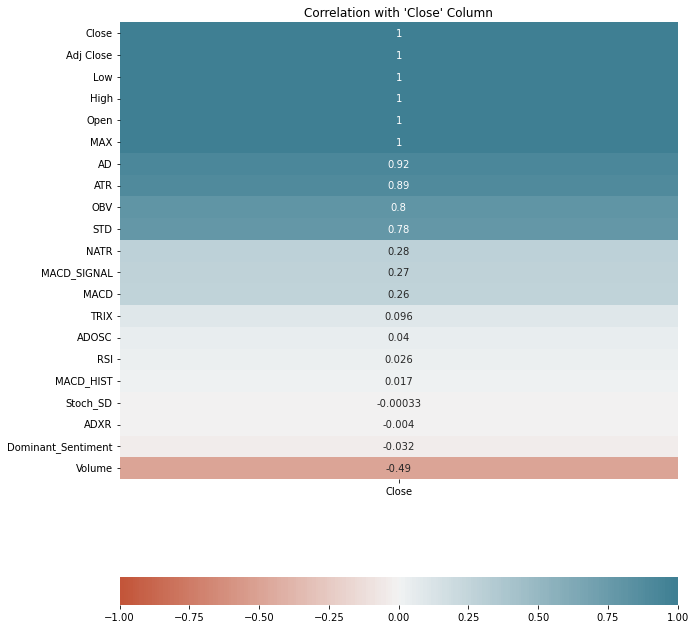

In [88]:
correlation_matrix = Dataset_D1.corr()

# Extracting correlation of all features with the 'Close' column
close_corr = correlation_matrix[['Close']]

plt.figure(figsize=(10, 12))
ax = sns.heatmap(close_corr.sort_values(by='Close', ascending=False), 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True,
                 cbar_kws={"orientation": "horizontal"})

ax.set_title("Correlation with 'Close' Column")
plt.show()

In [89]:
# ANOVA test to check if the means of the different levels of Dominant_Sentiment are significantly different in predicting the Close price

model = ols('Close ~ C(Dominant_Sentiment)', data=Dataset_D1).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                             sum_sq      df         F    PR(>F)
C(Dominant_Sentiment)  3.141941e+04     2.0  5.620756  0.003667
Residual               7.157854e+06  2561.0       NaN       NaN


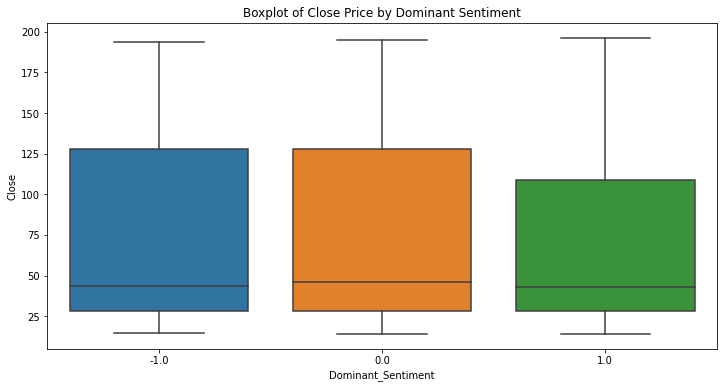

In [90]:
# Boxplot of Close Price by Dominant Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dominant_Sentiment', y='Close', data=Dataset_D1)
plt.title('Boxplot of Close Price by Dominant Sentiment')
plt.show()

In [91]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_D1[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'Dominant_Sentiment' ]]
y = Dataset_D1['Close']

# Split the data into training+validation and test datasets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size=0.1, shuffle=False)


In [92]:
# Model:

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

# Initialising the Expanding Window CV
tscv = TimeSeriesSplit(n_splits=5)

mae_list = []
mse_list = []
mape_list = []

# Looping through the train-test splits provided by expanding window
for train_index, test_index in tscv.split(X_train_val):
    
    x_train, x_test = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_test = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
    
    # Initialize the scaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both training and test data
    x_train_sc = scaler_x.fit_transform(x_train)
    x_test_sc = scaler_x.transform(x_test)

    y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Define the model
    model8 = Sequential()
    model8.add(LSTM(50, return_sequences=True, input_shape=(x_train_sc.shape[1], 1)))  # shape: (features, 1)
    model8.add(Dropout(0.1))
    model8.add(LSTM(50, return_sequences=False))
    model8.add(Dense(25))
    model8.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model8.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    # Train the model
    model_8 = model8.fit(x_train_sc, y_train_sc, epochs=20, batch_size=1, validation_data=(x_test_sc, y_test_sc), callbacks=[early_stopping])
    model8.summary()

    # Evaluate the model on the test dataset
    test_loss = model8.evaluate(x_test_sc, y_test_sc, verbose=1)
    print(f"Test Loss: {test_loss}")

    # Make predictions
    predicted_values = model8.predict(x_test_sc)

    #Performance Metrics 1:
    # Calculate Mean Absolute Error, Mean Squared Error,and MAPE
    mae = mean_absolute_error(y_test_sc, predicted_values)
    mse = mean_squared_error(y_test_sc, predicted_values)
    mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
    
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)

    print(f"-------------------performance metrics 1-----------------------------")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/20
387/387 [==============================] - 5s 8ms/step - loss: 0.0661 - val_loss: 0.0620
Epoch 2/20
387/387 [==============================] - 3s 8ms/step - loss: 0.0142 - val_loss: 0.0260
Epoch 3/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0074 - val_loss: 0.0233
Epoch 4/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0067 - val_loss: 0.0235
Epoch 5/20
387/387 [==============================] - 2s 6ms/step - loss: 0.0068 - val_loss: 0.0251
Epoch 6/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0229
Epoch 7/20
387/387 [==============================] - 3s 6ms/step - loss: 0.0066 - val_loss: 0.0223
Epoch 8/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0063 - val_loss: 0.0248
Epoch 9/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0184
Epoch 10/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0060 - val_loss: 0.0177

 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
12/12 [==============================] - 1s 4ms/step - loss: 0.0113
Test Loss: 0.011344282887876034
12/12 [==============================] - 1s 3ms/step
-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.08892804453888294
Mean Squared Error (MSE): 0.011344283878501069
Mean Absolute Percentage Error (MAPE): 8.009275452805255%
Epoch 1/20
1539/1539 [==============================] - 12s 6ms/step - loss: 0.0165 - val_loss: 0.0598
Epoch 2/20
1539/1539 [==============================] - 8s 5ms/step - loss: 0.0037 - val_loss: 0.0699
Epoch 3/20
1539/1539 [==============================] - 8s 5ms/step - loss: 0.0031 - val_loss: 0.1051
Epoch 4/20
1539/

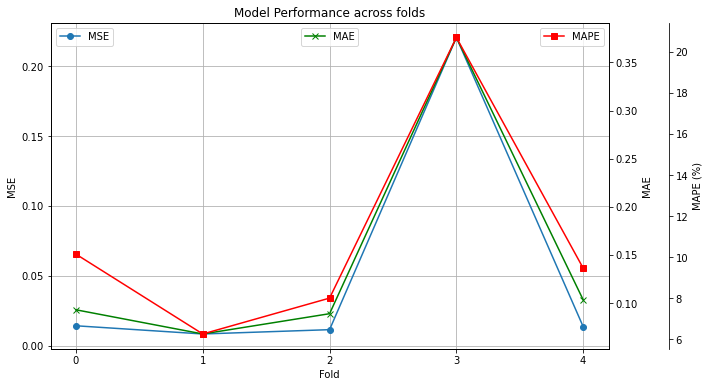

In [93]:
# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MSE values
ax1.plot(mse_list, marker='o', label='MSE')
ax1.set_title('Model Performance across folds')
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE')
ax1.grid(True)

# Setting the x-axis ticks with an interval of 1
ax1.set_xticks(range(len(mse_list)))

# Creating a second y-axis to plot MAE values
ax2 = ax1.twinx()
ax2.plot(mae_list, marker='x', color='g', label='MAE')
ax2.set_ylabel('MAE')

# Creating a third y-axis to plot MAPE values
ax3 = ax1.twinx()
# Offsetting the third y-axis 
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(mape_list, marker='s', color='r', label='MAPE')
ax3.set_ylabel('MAPE (%)')

# Adding a legend for each line
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')

plt.show()

9/9 [==============================] - 1s 5ms/step


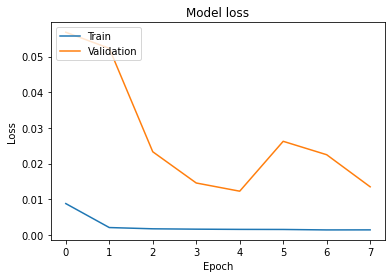

-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.08567564085077342
Mean Squared Error (MSE): 0.011173248458812046
Mean Absolute Percentage Error (MAPE): 6.867009966357767%
-------------------performance metrics 2-----------------------------
predicted_values greater than upper_bound: 19
predicted_values lesser than lower_bound: 125
No. of predicted values within the ±5.0% interval: 113 / 257
Percentage of predictions within the ±5.0% interval: 43.97%


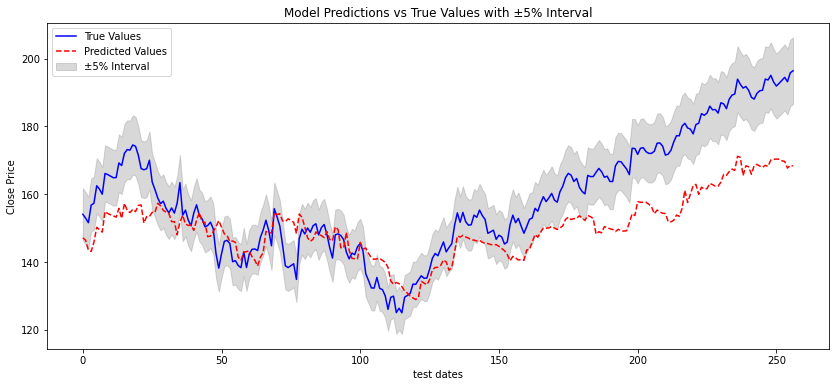

In [94]:
# transofrm the test data
X_test_sc = scaler_x.transform(X_test)
Y_test_sc = scaler_y.transform(Y_test.values.reshape(-1,1))

#predict with test data
predicted_values = model8.predict(X_test_sc)
y_test_sc = Y_test_sc

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(Y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

# Plot training & validation loss values
plt.plot(model_8.history['loss'])
plt.plot(model_8.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    
print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [95]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_8",
        'Experiment Description': f"Dataset_D1 with LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\4036750665.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model
6,Experiment_7,0.034891,0.001557,3.988539,18,34,196,248,79.032258,Dataset_C with hyp-parameter optimixed LSTM Model
7,Experiment_8,0.085676,0.011173,6.86701,19,125,113,257,43.968872,Dataset_D1 with LSTM Model


# Hyperparameter Tunning - Dataset_D1

In [96]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_D1[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'Dominant_Sentiment' ]]
y = Dataset_D1['Close']

# Split the data into training+validation and test datasets (90% train and val, 10% test)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Normalize the data

# Initialize the scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
x_train_val_sc = scaler_x.fit_transform(x_train_val)
x_test_sc = scaler_x.transform(x_test)

y_train_val_sc = scaler_y.fit_transform(y_train_val.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

# Split the temp dataset into train and validation datasets (90% train, 10% val)
x_train_sc, x_val_sc, y_train_sc, y_val_sc = train_test_split(x_train_val_sc, y_train_val_sc, test_size=0.1, shuffle=False)

# Convert to numpy arrays
x_train_sc, y_train_sc = np.array(x_train_sc), np.array(y_train_sc)
x_val_sc, y_val_sc = np.array(x_val_sc), np.array(y_val_sc)
x_test_sc, y_test_sc = np.array(x_test_sc), np.array(y_test_sc)

# Get the last value from y_train_temp for later use
previous_values = y_train_sc[-1:]

In [97]:
# LSTM Hyperparameter optimization modeling

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

def build_model(hp):
    model9 = keras.Sequential()
    
    # Input layer
    model9.add(layers.Input(shape=(x_train_sc.shape[1], 1)))
    
    # Dynamically add LSTM layers based on hyperparameters
    for i in range(hp.Int('num_layers', 1, 2)):  # for demonstration, adjust as needed
        model9.add(layers.LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32), 
                              return_sequences=True))
        model9.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    
    model9.add(layers.LSTM(units=hp.Int('final_lstm_units', min_value=32, max_value=256, step=32), 
                          return_sequences=False))
    model9.add(layers.Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    
    model9.add(layers.Dense(1))

    # Define learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model9.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )

    return model9

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    verbose=1,
    mode='min'
)

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='dataset_D1_LSTM_HP_exp_9'
)

tuner.search(
    x_train_sc, y_train_sc,
    epochs=20,
    validation_data=(x_val_sc, y_val_sc),
    callbacks = [early_stopping]
)

# Retrieve the best model and hyperparameters
best_model9 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters9 = tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

# Pull the summary of teh best model
best_model9.build(input_shape=(None, 28, 28))
best_model9.summary()

Trial 50 Complete [00h 00m 31s]
val_mean_squared_error: 0.007368180435150862

Best val_mean_squared_error So Far: 0.001727315247990191
Total elapsed time: 00h 20m 19s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\dataset_D1_LSTM_HP_exp_9
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 27 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 192
dropout_0: 0.4
final_lstm_units: 64
final_dropout: 0.0
learning_rate: 0.01
lstm_units_1: 160
dropout_1: 0.0
Score: 0.001727315247990191

Trial 26 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 224
dropout_0: 0.30000000000000004
final_lstm_units: 224
final_dropout: 0.1
learning_rate: 0.001
lstm_units_1: 32
dropout_1: 0.0
Score: 0.0021070672664791346

Trial 37 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 64
dropout_0: 0.0
final_lstm_units: 160
final_dropout: 0.2
learning_rate: 0.001
lstm_units_1: 128
dropout_1: 0.2
Score: 0.0030579061713069677

Trial 34 summary
Hyperpar

# Experiment_9
Dataset_D1 with Hyperparameter Optimized best LSTM Model - - - - - - - Output_9

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 192)            148992    
                                                                 
 dropout (Dropout)           (None, 6, 192)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                65792     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 214849 (839.25 KB)
Trainable params: 214849 (839.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
9/9 [===========

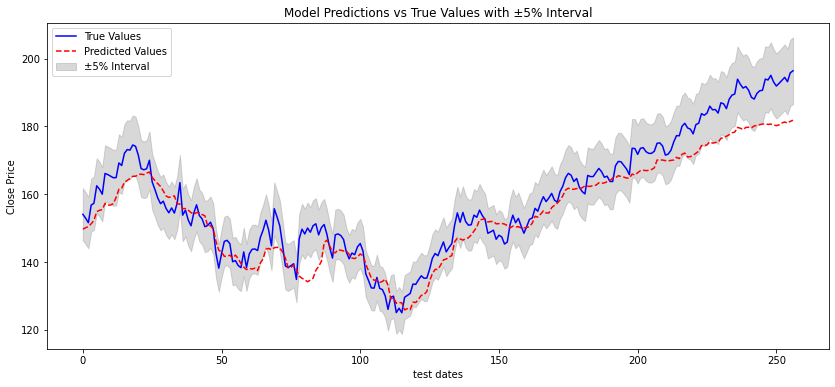

In [98]:
# Pull the summary of teh best model
best_model9.build(input_shape=(None, 28, 28))
best_model9.summary()

# Predict the x_test with best model
predicted_values = best_model9.predict(x_test_sc)

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [99]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_9",
        'Experiment Description': f"Dataset_D1 with hyp-parameter optimixed LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\2620302396.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model
6,Experiment_7,0.034891,0.001557,3.988539,18,34,196,248,79.032258,Dataset_C with hyp-parameter optimixed LSTM Model
7,Experiment_8,0.085676,0.011173,6.86701,19,125,113,257,43.968872,Dataset_D1 with LSTM Model
8,Experiment_9,0.030614,0.001433,3.436529,1,49,207,257,80.544747,Dataset_D1 with hyp-parameter optimixed LSTM M...


# Dataset_D2
Historical stock price + Technical Indicators + Financial News NYT (FinBERT)

In [100]:
# Merge TI+FN (without FI)

#Load sentiment data from the sentiment analysis sheet
import pickle

with open("fn_senti_finbert.pkl", "rb") as file:
    fn_senti_finbert = pickle.load(file)
fn_senti_finbert

apple_ds_d2 = Dataset_A.copy()
apple_ds_d2.info()

tifn_fin_merged_df = apple_ds_d2.merge(fn_senti_finbert, on='Date', how='outer')
tifn_fin_merged_df['Dominant_Sentiment'].fillna(method="ffill", inplace=True)
tifn_fin_merged_df.head(60)

rows_with_na8 = tifn_fin_merged_df[tifn_fin_merged_df.isna().any(axis=1)]
rows_with_na8

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na8.index

# Drop these rows with NaN
tifn_fin_merged_df = tifn_fin_merged_df.drop(indices_to_drop)
tifn_fin_merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 97 to 2661
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2565 non-null   datetime64[ns]
 1   Open         2565 non-null   float64       
 2   High         2565 non-null   float64       
 3   Low          2565 non-null   float64       
 4   Close        2565 non-null   float64       
 5   Adj Close    2565 non-null   float64       
 6   Volume       2565 non-null   int64         
 7   MACD         2565 non-null   float64       
 8   MACD_SIGNAL  2565 non-null   float64       
 9   MACD_HIST    2565 non-null   float64       
 10  ATR          2565 non-null   float64       
 11  RSI          2565 non-null   float64       
 12  OBV          2565 non-null   float64       
 13  NATR         2565 non-null   float64       
 14  ADXR         2565 non-null   float64       
 15  TRIX         2565 non-null   float64       
 16  ADOSC

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD,Dominant_Sentiment
1,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200.0,0.082279,0.114230,-0.031951,...,-4.855063e+09,2.694904,23.377643,-0.087777,-1.123016e+07,-4.723582e+09,68.797273,16.240713,0.290157,-1.0
2,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800.0,0.087301,0.108844,-0.021543,...,-4.578896e+09,2.570533,23.242826,-0.080859,6.483261e+07,-4.500564e+09,73.738997,16.240713,0.257723,1.0
3,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200.0,0.079672,0.103010,-0.023338,...,-4.965041e+09,2.572999,22.894041,-0.074318,-1.867904e+07,-4.842301e+09,70.588906,15.898214,0.189405,1.0
4,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400.0,0.082786,0.098965,-0.016179,...,-4.634465e+09,2.500397,22.536068,-0.067932,-1.218826e+07,-4.719866e+09,66.777089,15.898214,0.193463,-1.0
5,2013-05-30,15.916071,16.232143,15.875357,16.127857,13.983276,353519600.0,0.103172,0.099806,0.003366,...,-4.280945e+09,2.445726,22.181210,-0.061328,3.830235e+07,-4.573009e+09,62.591568,16.127857,0.187501,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200.0,2.657851,2.960267,-0.302416,...,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751,0.0
2561,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900.0,2.647809,2.897775,-0.249967,...,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903,0.0
2562,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200.0,2.507658,2.819752,-0.312094,...,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316,0.0
2563,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400.0,2.577481,2.771298,-0.193817,...,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057,0.0


In [101]:
Dataset_D2 = tifn_fin_merged_df

# Experiment_10
Dataset_D2 with LSTM Model - - - - - - - Output_10

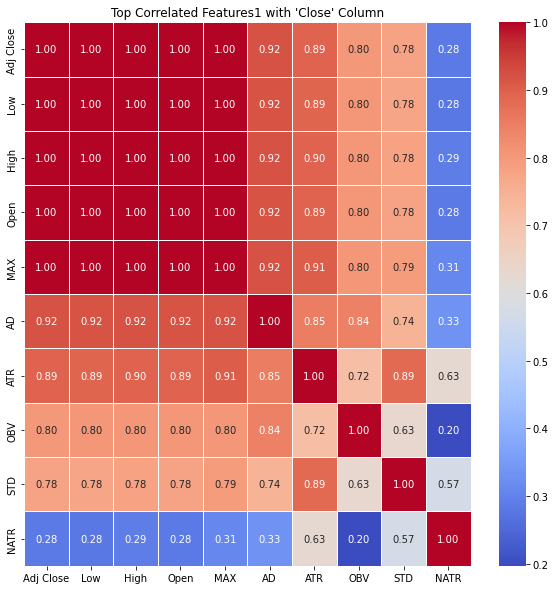

In [102]:
# Feature Selection for Dataset_D2

correlation_matrix = Dataset_D2.corr()

# Selecting top correlated features with the 'Close' column as an example target variable
top_correlated_features = correlation_matrix['Close'].sort_values(ascending=False).head(11).index[1:]

# Getting the top correlation values
top_corr_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

# Plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Top Correlated Features1 with 'Close' Column")
plt.show()

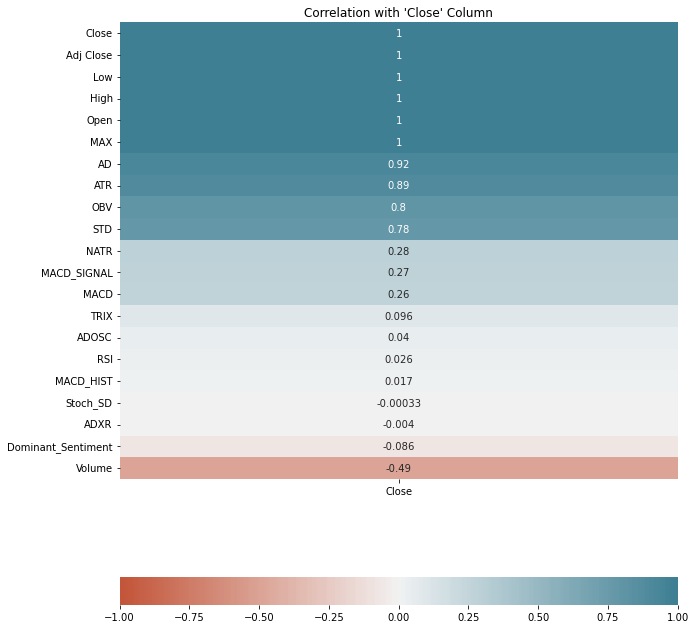

In [103]:
correlation_matrix = Dataset_D2.corr()

# Extracting correlation of all features with the 'Close' column
close_corr = correlation_matrix[['Close']]

plt.figure(figsize=(10, 12))
ax = sns.heatmap(close_corr.sort_values(by='Close', ascending=False), 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True,
                 cbar_kws={"orientation": "horizontal"})

ax.set_title("Correlation with 'Close' Column")
plt.show()

In [104]:
# ANOVA test to check if the means of the different levels of Dominant_Sentiment are significantly different in predicting the Close price

model = ols('Close ~ C(Dominant_Sentiment)', data=Dataset_D2).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                             sum_sq      df        F    PR(>F)
C(Dominant_Sentiment)  5.297452e+04     2.0  9.50547  0.000077
Residual               7.136299e+06  2561.0      NaN       NaN


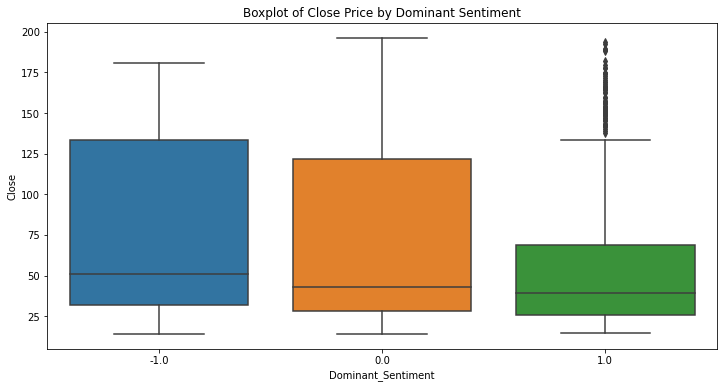

In [105]:
# Boxplot of Close Price by Dominant Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dominant_Sentiment', y='Close', data=Dataset_D2)
plt.title('Boxplot of Close Price by Dominant Sentiment')
plt.show()

In [106]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_D2[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'Dominant_Sentiment' ]]
y = Dataset_D2['Close']

# Split the data into training+validation and test datasets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size=0.1, shuffle=False)


In [107]:
# Model:

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

# Initialising the Expanding Window CV
tscv = TimeSeriesSplit(n_splits=5)

mae_list = []
mse_list = []
mape_list = []

# Looping through the train-test splits provided by expanding window
for train_index, test_index in tscv.split(X_train_val):
    
    x_train, x_test = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_test = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
    
    # Initialize the scaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both training and test data
    x_train_sc = scaler_x.fit_transform(x_train)
    x_test_sc = scaler_x.transform(x_test)

    y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Define the model
    model10 = Sequential()
    model10.add(LSTM(50, return_sequences=True, input_shape=(x_train_sc.shape[1], 1)))  # shape: (features, 1)
    model10.add(Dropout(0.1))
    model10.add(LSTM(50, return_sequences=False))
    model10.add(Dense(25))
    model10.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model10.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    # Train the model
    model_10 = model10.fit(x_train_sc, y_train_sc, epochs=20, batch_size=1, validation_data=(x_test_sc, y_test_sc), callbacks=[early_stopping])
    model10.summary()

    # Evaluate the model on the test dataset
    test_loss = model10.evaluate(x_test_sc, y_test_sc, verbose=1)
    print(f"Test Loss: {test_loss}")

    # Make predictions
    predicted_values = model10.predict(x_test_sc)

    #Performance Metrics 1:
    # Calculate Mean Absolute Error, Mean Squared Error,and MAPE
    mae = mean_absolute_error(y_test_sc, predicted_values)
    mse = mean_squared_error(y_test_sc, predicted_values)
    mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
    
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)

    print(f"-------------------performance metrics 1-----------------------------")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/20
387/387 [==============================] - 6s 9ms/step - loss: 0.0455 - val_loss: 0.0454
Epoch 2/20
387/387 [==============================] - 3s 6ms/step - loss: 0.0107 - val_loss: 0.0249
Epoch 3/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0069 - val_loss: 0.0230
Epoch 4/20
387/387 [==============================] - 2s 6ms/step - loss: 0.0067 - val_loss: 0.0225
Epoch 5/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0068 - val_loss: 0.0214
Epoch 6/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0065 - val_loss: 0.0221
Epoch 7/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0066 - val_loss: 0.0206
Epoch 8/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0064 - val_loss: 0.0218
Epoch 9/20
387/387 [==============================] - 3s 6ms/step - loss: 0.0063 - val_loss: 0.0186
Epoch 10/20
387/387 [==============================] - 2s 6ms/step - loss: 0.0060 - val_loss: 0.0176

 dropout_4 (Dropout)         (None, 6, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 25)                1275      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
12/12 [==============================] - 1s 5ms/step - loss: 0.0107
Test Loss: 0.010660775937139988
12/12 [==============================] - 1s 3ms/step
-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.08549522402676425
Mean Squared Error (MSE): 0.0106

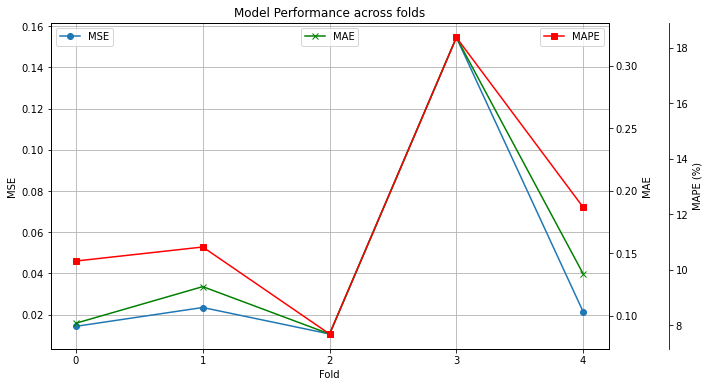

In [108]:
# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MSE values
ax1.plot(mse_list, marker='o', label='MSE')
ax1.set_title('Model Performance across folds')
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE')
ax1.grid(True)

# Setting the x-axis ticks with an interval of 1
ax1.set_xticks(range(len(mse_list)))

# Creating a second y-axis to plot MAE values
ax2 = ax1.twinx()
ax2.plot(mae_list, marker='x', color='g', label='MAE')
ax2.set_ylabel('MAE')

# Creating a third y-axis to plot MAPE values
ax3 = ax1.twinx()
# Offsetting the third y-axis 
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(mape_list, marker='s', color='r', label='MAPE')
ax3.set_ylabel('MAPE (%)')

# Adding a legend for each line
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')

plt.show()

9/9 [==============================] - 1s 4ms/step


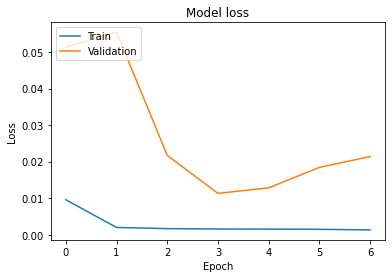

-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.11442319295002416
Mean Squared Error (MSE): 0.018159416294649268
Mean Absolute Percentage Error (MAPE): 9.18942761094447%
-------------------performance metrics 2-----------------------------
predicted_values greater than upper_bound: 7
predicted_values lesser than lower_bound: 177
No. of predicted values within the ±5.0% interval: 73 / 257
Percentage of predictions within the ±5.0% interval: 28.40%


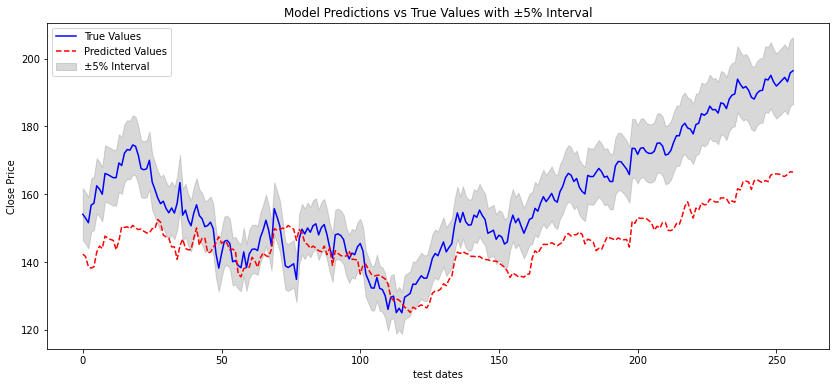

In [109]:
# transofrm the test data
X_test_sc = scaler_x.transform(X_test)
Y_test_sc = scaler_y.transform(Y_test.values.reshape(-1,1))

#predict with test data
predicted_values = model10.predict(X_test_sc)
y_test_sc = Y_test_sc

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(Y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

# Plot training & validation loss values
plt.plot(model_10.history['loss'])
plt.plot(model_10.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")
    
print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [110]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_10",
        'Experiment Description': f"Dataset_D2 with LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\1241979103.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model
6,Experiment_7,0.034891,0.001557,3.988539,18,34,196,248,79.032258,Dataset_C with hyp-parameter optimixed LSTM Model
7,Experiment_8,0.085676,0.011173,6.86701,19,125,113,257,43.968872,Dataset_D1 with LSTM Model
8,Experiment_9,0.030614,0.001433,3.436529,1,49,207,257,80.544747,Dataset_D1 with hyp-parameter optimixed LSTM M...
9,Experiment_10,0.114423,0.018159,9.189428,7,177,73,257,28.404669,Dataset_D2 with LSTM Model


# Hyperparameter Tunning - Dataset_D2

In [111]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_D2[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'Dominant_Sentiment' ]]
y = Dataset_D2['Close']

# Split the data into training+validation and test datasets (90% train and val, 10% test)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Normalize the data

# Initialize the scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
x_train_val_sc = scaler_x.fit_transform(x_train_val)
x_test_sc = scaler_x.transform(x_test)

y_train_val_sc = scaler_y.fit_transform(y_train_val.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

# Split the temp dataset into train and validation datasets (90% train, 10% val)
x_train_sc, x_val_sc, y_train_sc, y_val_sc = train_test_split(x_train_val_sc, y_train_val_sc, test_size=0.1, shuffle=False)

# Convert to numpy arrays
x_train_sc, y_train_sc = np.array(x_train_sc), np.array(y_train_sc)
x_val_sc, y_val_sc = np.array(x_val_sc), np.array(y_val_sc)
x_test_sc, y_test_sc = np.array(x_test_sc), np.array(y_test_sc)

# Get the last value from y_train_temp for later use
previous_values = y_train_sc[-1:]

In [112]:
# LSTM Hyperparameter optimization modeling

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

def build_model(hp):
    model11 = keras.Sequential()
    
    # Input layer
    model11.add(layers.Input(shape=(x_train_sc.shape[1], 1)))
    
    # Dynamically add LSTM layers based on hyperparameters
    for i in range(hp.Int('num_layers', 1, 2)):  # for demonstration, adjust as needed
        model11.add(layers.LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32), 
                              return_sequences=True))
        model11.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    
    model11.add(layers.LSTM(units=hp.Int('final_lstm_units', min_value=32, max_value=256, step=32), 
                          return_sequences=False))
    model11.add(layers.Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    model11.add(layers.Dense(1))

    # Define learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model11.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )

    return model11

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    verbose=1,
    mode='min'
)

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='dataset_D2_LSTM_HP_exp_11'
)

tuner.search(
    x_train_sc, y_train_sc,
    epochs=20,
    validation_data=(x_val_sc, y_val_sc),
    callbacks=[early_stopping]
)

# Retrieve the best model and hyperparameters
best_model11 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters11 = tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

# Pull the summary of teh best model
best_model11.build(input_shape=(None, 28, 28))
best_model11.summary()

Trial 50 Complete [00h 00m 25s]
val_mean_squared_error: 0.00437657255679369

Best val_mean_squared_error So Far: 0.0013046710519120097
Total elapsed time: 00h 20m 34s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\dataset_D2_LSTM_HP_exp_11
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 30 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 96
dropout_0: 0.0
final_lstm_units: 128
final_dropout: 0.0
learning_rate: 0.001
lstm_units_1: 256
dropout_1: 0.0
Score: 0.0013046710519120097

Trial 22 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 128
dropout_0: 0.0
final_lstm_units: 256
final_dropout: 0.4
learning_rate: 0.01
lstm_units_1: 128
dropout_1: 0.1
Score: 0.0013373723486438394

Trial 05 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 256
dropout_0: 0.4
final_lstm_units: 32
final_dropout: 0.1
learning_rate: 0.001
lstm_units_1: 32
dropout_1: 0.2
Score: 0.0022278432734310627

Trial 10 summary
Hyperparameters:
num_l

# Experiment_11
Dataset_D2 with Hyperparameter Optimized best LSTM Model - - - - - - - Output_11

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 96)             37632     
                                                                 
 dropout (Dropout)           (None, 6, 96)             0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 256)            361472    
                                                                 
 dropout_1 (Dropout)         (None, 6, 256)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

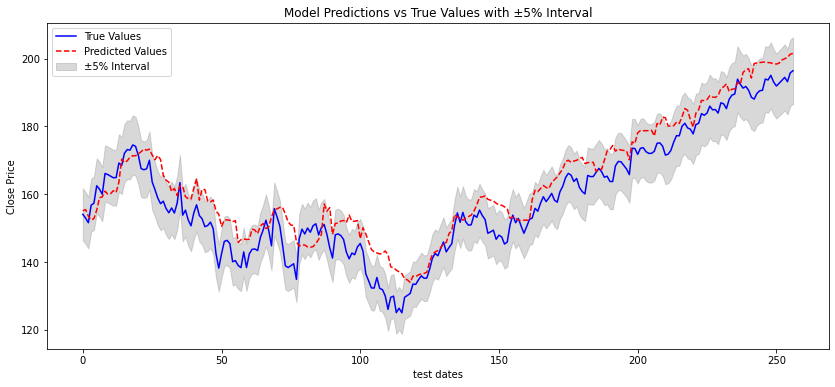

In [113]:
# Pull the summary of teh best model
best_model11.build(input_shape=(None, 28, 28))
best_model11.summary()

# Predict the x_test with best model
predicted_values = best_model11.predict(x_test_sc)

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [114]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_11",
        'Experiment Description': f"Dataset_D2 with hyp-parameter optimixed LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\4261042556.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model
6,Experiment_7,0.034891,0.001557,3.988539,18,34,196,248,79.032258,Dataset_C with hyp-parameter optimixed LSTM Model
7,Experiment_8,0.085676,0.011173,6.86701,19,125,113,257,43.968872,Dataset_D1 with LSTM Model
8,Experiment_9,0.030614,0.001433,3.436529,1,49,207,257,80.544747,Dataset_D1 with hyp-parameter optimixed LSTM M...
9,Experiment_10,0.114423,0.018159,9.189428,7,177,73,257,28.404669,Dataset_D2 with LSTM Model


# Dataset_D3
Historical stock price + Technical Indicators + Financial News NYT (ChatGPT-3.5)

In [115]:
# Merge TI+FN (without FI)

#Load sentiment data from the sentiment analysis sheet
import pickle

with open("fn_senti_ChatGPT.pkl", "rb") as file:
    fn_senti_chatGPT = pickle.load(file)
fn_senti_chatGPT

apple_ds_d3 = Dataset_A.copy()
apple_ds_d3.info()

tifn_chatGPT_merged_df = apple_ds_d3.merge(fn_senti_chatGPT, on='Date', how='outer')
tifn_chatGPT_merged_df['Dominant_prediction'].fillna(method="ffill", inplace=True)
tifn_chatGPT_merged_df.head(60)

rows_with_na8 = tifn_chatGPT_merged_df[tifn_chatGPT_merged_df.isna().any(axis=1)]
rows_with_na8

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na8.index

# Drop these rows with NaN
tifn_chatGPT_merged_df = tifn_chatGPT_merged_df.drop(indices_to_drop)
tifn_chatGPT_merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 97 to 2661
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2565 non-null   datetime64[ns]
 1   Open         2565 non-null   float64       
 2   High         2565 non-null   float64       
 3   Low          2565 non-null   float64       
 4   Close        2565 non-null   float64       
 5   Adj Close    2565 non-null   float64       
 6   Volume       2565 non-null   int64         
 7   MACD         2565 non-null   float64       
 8   MACD_SIGNAL  2565 non-null   float64       
 9   MACD_HIST    2565 non-null   float64       
 10  ATR          2565 non-null   float64       
 11  RSI          2565 non-null   float64       
 12  OBV          2565 non-null   float64       
 13  NATR         2565 non-null   float64       
 14  ADXR         2565 non-null   float64       
 15  TRIX         2565 non-null   float64       
 16  ADOSC

,Date,Open,High,Low,Close,Adj Close,Volume,MACD,MACD_SIGNAL,MACD_HIST,...,OBV,NATR,ADXR,TRIX,ADOSC,AD,Stoch_SD,MAX,STD,Dominant_prediction
1,2013-05-23,15.569643,15.934286,15.563929,15.790714,13.690963,353021200.0,0.082279,0.114230,-0.031951,...,-4.855063e+09,2.694904,23.377643,-0.087777,-1.123016e+07,-4.723582e+09,68.797273,16.240713,0.290157,-1.0
2,2013-05-24,15.744643,15.916429,15.727143,15.898214,13.784173,276166800.0,0.087301,0.108844,-0.021543,...,-4.578896e+09,2.570533,23.242826,-0.080859,6.483261e+07,-4.500564e+09,73.738997,16.240713,0.257723,1.0
3,2013-05-28,16.067858,16.111071,15.744643,15.765714,13.669287,386145200.0,0.079672,0.103010,-0.023338,...,-4.965041e+09,2.572999,22.894041,-0.074318,-1.867904e+07,-4.842301e+09,70.588906,15.898214,0.189405,1.0
4,2013-05-29,15.714286,15.982143,15.692857,15.891071,13.777977,330576400.0,0.082786,0.098965,-0.016179,...,-4.634465e+09,2.500397,22.536068,-0.067932,-1.218826e+07,-4.719866e+09,66.777089,15.898214,0.193463,-1.0
5,2013-05-30,15.916071,16.232143,15.875357,16.127857,13.983276,353519600.0,0.103172,0.099806,0.003366,...,-4.280945e+09,2.445726,22.181210,-0.061328,3.830235e+07,-4.573009e+09,62.591568,16.127857,0.187501,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2560,2023-07-25,193.330002,194.440002,192.919998,193.619995,193.358887,37283200.0,2.657851,2.960267,-0.302416,...,5.166871e+09,1.502205,46.435021,0.260423,-3.184482e+07,7.118019e+09,28.111174,195.100006,1.734751,0.0
2561,2023-07-26,193.669998,195.639999,193.320007,194.500000,194.237701,47471900.0,2.647809,2.897775,-0.249967,...,5.214343e+09,1.473793,46.337780,0.258739,-3.099630e+07,7.118838e+09,28.535217,195.100006,1.532903,0.0
2562,2023-07-27,196.020004,197.199997,192.550003,193.220001,192.959427,47460200.0,2.507658,2.819752,-0.312094,...,5.166883e+09,1.549487,45.523478,0.256758,-3.858064e+07,7.085054e+09,34.904756,195.100006,1.266316,-1.0
2563,2023-07-28,194.669998,196.630005,194.139999,195.830002,195.565918,48291400.0,2.577481,2.771298,-0.193817,...,5.215174e+09,1.544012,44.658510,0.254881,-3.268394e+07,7.102315e+09,46.244887,195.830002,1.141057,-1.0


In [116]:
Dataset_D3 = tifn_chatGPT_merged_df

# Experiment_12
Dataset_D3 with LSTM Model - - - - - - - Output_12

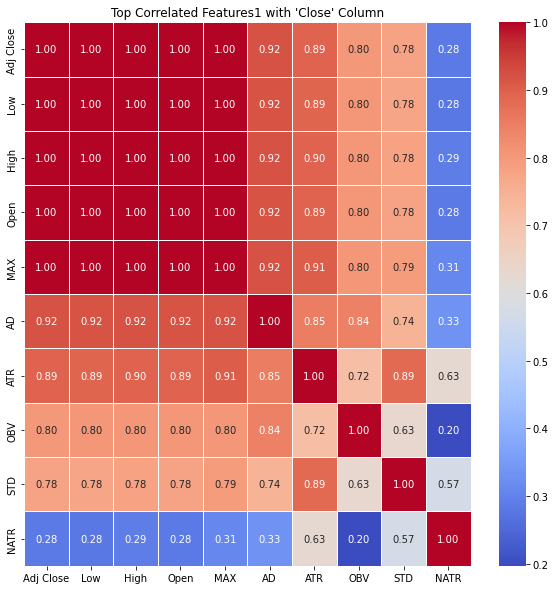

In [117]:
# Feature Selection for Dataset_D2

correlation_matrix = Dataset_D3.corr()

# Selecting top correlated features with the 'Close' column as an example target variable
top_correlated_features = correlation_matrix['Close'].sort_values(ascending=False).head(11).index[1:]

# Getting the top correlation values
top_corr_matrix = correlation_matrix.loc[top_correlated_features, top_correlated_features]

# Plotting the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Top Correlated Features1 with 'Close' Column")
plt.show()

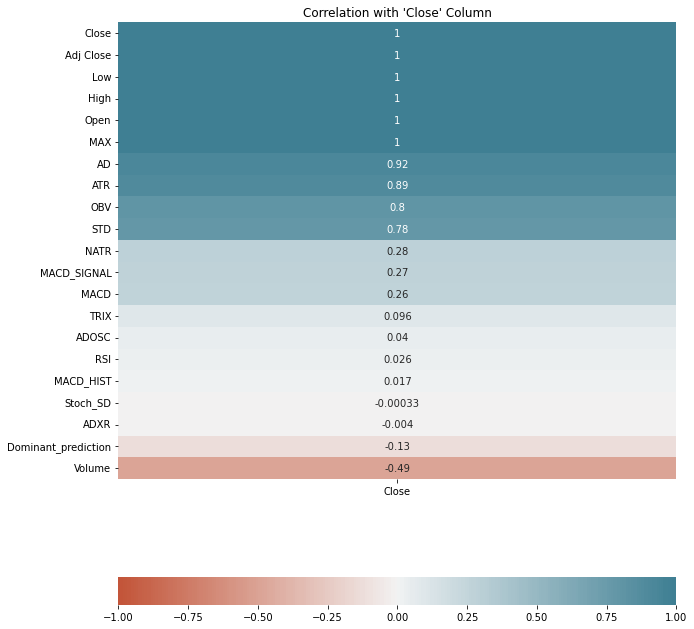

In [118]:
correlation_matrix = Dataset_D3.corr()

# Extracting correlation of all features with the 'Close' column
close_corr = correlation_matrix[['Close']]

plt.figure(figsize=(10, 12))
ax = sns.heatmap(close_corr.sort_values(by='Close', ascending=False), 
                 vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 annot=True,
                 cbar_kws={"orientation": "horizontal"})

ax.set_title("Correlation with 'Close' Column")
plt.show()

In [119]:
# ANOVA test to check if the means of the different levels of Dominant_Sentiment are significantly different in predicting the Close price

model = ols('Close ~ C(Dominant_prediction)', data=Dataset_D3).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                              sum_sq      df          F        PR(>F)
C(Dominant_prediction)  2.066883e+05     2.0  37.903483  5.993137e-17
Residual                6.982585e+06  2561.0        NaN           NaN


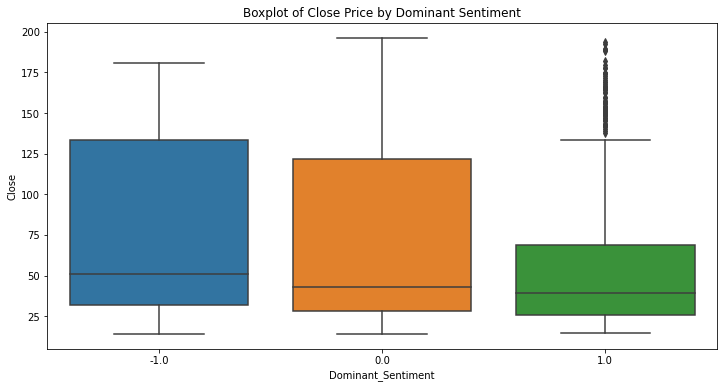

In [120]:
# Boxplot of Close Price by Dominant Sentiment
plt.figure(figsize=(12, 6))
sns.boxplot(x='Dominant_Sentiment', y='Close', data=Dataset_D2)
plt.title('Boxplot of Close Price by Dominant Sentiment')
plt.show()

In [121]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_D3[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'Dominant_prediction' ]]
y = Dataset_D3['Close']

# Split the data into training+validation and test datasets
X_train_val, X_test, Y_train_val, Y_test = train_test_split(x, y, test_size=0.1, shuffle=False)


In [122]:
# Model:

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

# Initialising the Expanding Window CV
tscv = TimeSeriesSplit(n_splits=5)

mae_list = []
mse_list = []
mape_list = []

# Looping through the train-test splits provided by expanding window
for train_index, test_index in tscv.split(X_train_val):
    
    x_train, x_test = X_train_val.iloc[train_index], X_train_val.iloc[test_index]
    y_train, y_test = Y_train_val.iloc[train_index], Y_train_val.iloc[test_index]
    
    # Initialize the scaler
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    
    # Fit the scaler on the training data and transform both training and test data
    x_train_sc = scaler_x.fit_transform(x_train)
    x_test_sc = scaler_x.transform(x_test)

    y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
    y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Define the model
    model12 = Sequential()
    model12.add(LSTM(50, return_sequences=True, input_shape=(x_train_sc.shape[1], 1)))  # shape: (features, 1)
    model12.add(Dropout(0.1))
    model12.add(LSTM(50, return_sequences=False))
    model12.add(Dense(25))
    model12.add(Dense(1))

    # Compile the model
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model12.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min')

    # Train the model
    model_12 = model12.fit(x_train_sc, y_train_sc, epochs=20, batch_size=1, validation_data=(x_test_sc, y_test_sc), callbacks=[early_stopping])
    model12.summary()

    # Evaluate the model on the test dataset
    test_loss = model12.evaluate(x_test_sc, y_test_sc, verbose=1)
    print(f"Test Loss: {test_loss}")

    # Make predictions
    predicted_values = model12.predict(x_test_sc)

    #Performance Metrics 1:
    # Calculate Mean Absolute Error, Mean Squared Error,and MAPE
    mae = mean_absolute_error(y_test_sc, predicted_values)
    mse = mean_squared_error(y_test_sc, predicted_values)
    mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
    
    mae_list.append(mae)
    mse_list.append(mse)
    mape_list.append(mape)

    print(f"-------------------performance metrics 1-----------------------------")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

Epoch 1/20
387/387 [==============================] - 6s 9ms/step - loss: 0.0444 - val_loss: 0.0447
Epoch 2/20
387/387 [==============================] - 3s 6ms/step - loss: 0.0112 - val_loss: 0.0263
Epoch 3/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0072 - val_loss: 0.0255
Epoch 4/20
387/387 [==============================] - 3s 8ms/step - loss: 0.0069 - val_loss: 0.0249
Epoch 5/20
387/387 [==============================] - 3s 8ms/step - loss: 0.0068 - val_loss: 0.0238
Epoch 6/20
387/387 [==============================] - 3s 8ms/step - loss: 0.0066 - val_loss: 0.0256
Epoch 7/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0067 - val_loss: 0.0225
Epoch 8/20
387/387 [==============================] - 3s 7ms/step - loss: 0.0063 - val_loss: 0.0279
Epoch 9/20
387/387 [==============================] - 3s 8ms/step - loss: 0.0065 - val_loss: 0.0202
Epoch 10/20
387/387 [==============================] - 3s 9ms/step - loss: 0.0061 - val_loss: 0.0194

 dropout_5 (Dropout)         (None, 6, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 25)                1275      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
12/12 [==============================] - 1s 3ms/step - loss: 0.0086
Test Loss: 0.008645822294056416
12/12 [==============================] - 1s 3ms/step
-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.07544174159733755
Mean Squared Error (MSE): 0.0086

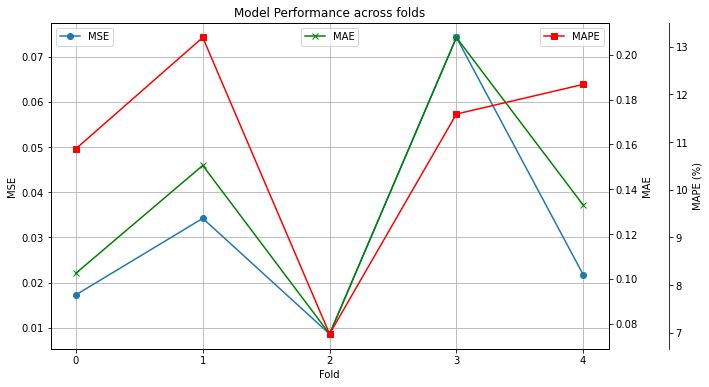

In [123]:
# Creating a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting MSE values
ax1.plot(mse_list, marker='o', label='MSE')
ax1.set_title('Model Performance across folds')
ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE')
ax1.grid(True)

# Setting the x-axis ticks with an interval of 1
ax1.set_xticks(range(len(mse_list)))

# Creating a second y-axis to plot MAE values
ax2 = ax1.twinx()
ax2.plot(mae_list, marker='x', color='g', label='MAE')
ax2.set_ylabel('MAE')

# Creating a third y-axis to plot MAPE values
ax3 = ax1.twinx()
# Offsetting the third y-axis 
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(mape_list, marker='s', color='r', label='MAPE')
ax3.set_ylabel('MAPE (%)')

# Adding a legend for each line
ax1.legend(loc='upper left')
ax2.legend(loc='upper center')
ax3.legend(loc='upper right')

plt.show()

9/9 [==============================] - 1s 3ms/step


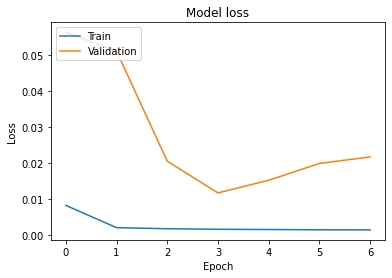

-------------------performance metrics 1-----------------------------
Mean Absolute Error (MAE): 0.11614150645923807
Mean Squared Error (MSE): 0.019012241804641887
Mean Absolute Percentage Error (MAPE): 9.316220391736856%
-------------------performance metrics 2-----------------------------
predicted_values greater than upper_bound: 7
predicted_values lesser than lower_bound: 171
No. of predicted values within the ±5.0% interval: 79 / 257
Percentage of predictions within the ±5.0% interval: 30.74%


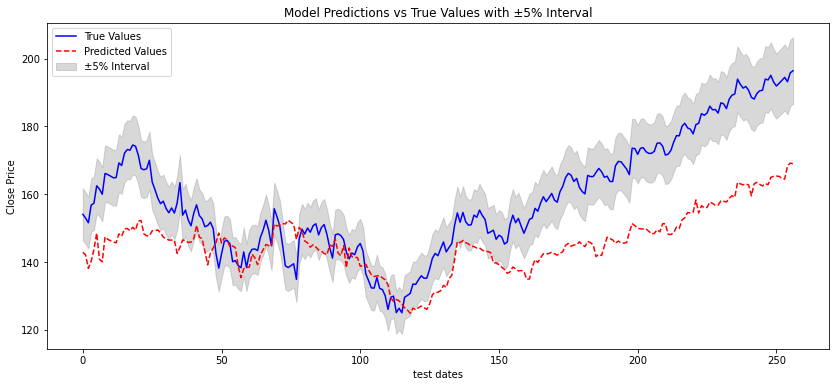

In [124]:
# transofrm the test data
X_test_sc = scaler_x.transform(X_test)
Y_test_sc = scaler_y.transform(Y_test.values.reshape(-1,1))

#predict with test data
predicted_values = model12.predict(X_test_sc)
y_test_sc = Y_test_sc

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(Y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

# Plot training & validation loss values
plt.plot(model_12.history['loss'])
plt.plot(model_12.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
    
#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [125]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_12",
        'Experiment Description': f"Dataset_D3 with LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\2105817348.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model
6,Experiment_7,0.034891,0.001557,3.988539,18,34,196,248,79.032258,Dataset_C with hyp-parameter optimixed LSTM Model
7,Experiment_8,0.085676,0.011173,6.86701,19,125,113,257,43.968872,Dataset_D1 with LSTM Model
8,Experiment_9,0.030614,0.001433,3.436529,1,49,207,257,80.544747,Dataset_D1 with hyp-parameter optimixed LSTM M...
9,Experiment_10,0.114423,0.018159,9.189428,7,177,73,257,28.404669,Dataset_D2 with LSTM Model


# Hyperparameter Tunning - Dataset_D3

In [126]:
# Model - TRAIN AND TEST SPLIT 

# Dependent and independent variables  
x = Dataset_D3[['MAX', 'AD', 'ATR', 'OBV', 'STD', 'Dominant_prediction' ]]
y = Dataset_D3['Close']

# Split the data into training+validation and test datasets (90% train and val, 10% test)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

# Normalize the data

# Initialize the scaler
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the training data and transform both training and test data
x_train_val_sc = scaler_x.fit_transform(x_train_val)
x_test_sc = scaler_x.transform(x_test)

y_train_val_sc = scaler_y.fit_transform(y_train_val.values.reshape(-1, 1))
y_test_sc = scaler_y.transform(y_test.values.reshape(-1, 1))

# Split the temp dataset into train and validation datasets (90% train, 10% val)
x_train_sc, x_val_sc, y_train_sc, y_val_sc = train_test_split(x_train_val_sc, y_train_val_sc, test_size=0.1, shuffle=False)

# Convert to numpy arrays
x_train_sc, y_train_sc = np.array(x_train_sc), np.array(y_train_sc)
x_val_sc, y_val_sc = np.array(x_val_sc), np.array(y_val_sc)
x_test_sc, y_test_sc = np.array(x_test_sc), np.array(y_test_sc)

# Get the last value from y_train_temp for later use
previous_values = y_train_sc[-1:]

In [127]:
# LSTM Hyperparameter optimization modeling

# Set the random seeds for both numpy and tensorflow
np.random.seed(130)
tf.random.set_seed(130)

def build_model(hp):
    model13 = keras.Sequential()
    
    # Input layer
    model13.add(layers.Input(shape=(x_train_sc.shape[1], 1)))
    
    # Dynamically add LSTM layers based on hyperparameters
    for i in range(hp.Int('num_layers', 1, 2)):  # for demonstration, adjust as needed
        model13.add(layers.LSTM(units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=256, step=32), 
                              return_sequences=True))
        model13.add(layers.Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    
    
    model13.add(layers.LSTM(units=hp.Int('final_lstm_units', min_value=32, max_value=256, step=32), 
                          return_sequences=False))
    model13.add(layers.Dropout(hp.Float('final_dropout', min_value=0.0, max_value=0.5, step=0.1)))
    
    model13.add(layers.Dense(1))

    # Define learning rate for Adam optimizer
    learning_rate = hp.Choice('learning_rate', [0.1, 0.01, 0.001, 0.0001])
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model13.compile(
        optimizer=opt,
        loss='mean_squared_error',
        metrics=['mean_squared_error']
    )

    return model13

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    verbose=1,
    mode='min'
)

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_mean_squared_error", direction="min"),
    max_trials=50,
    executions_per_trial=1,
    overwrite=True,
    directory='my_dir',
    project_name='dataset_D3_LSTM_HP_exp_13'
)

tuner.search(
    x_train_sc, y_train_sc,
    epochs=20,
    validation_data=(x_val_sc, y_val_sc),
    callbacks=[early_stopping]
)

# Retrieve the best model and hyperparameters
best_model13 = tuner.get_best_models(num_models=1)[0]
best_hyperparameters13 = tuner.get_best_hyperparameters(num_trials=1)[0]

tuner.results_summary()

# Pull the summary of teh best model
best_model13.build(input_shape=(None, 28, 28))
best_model13.summary()


Trial 50 Complete [00h 00m 18s]
val_mean_squared_error: 0.006877067498862743

Best val_mean_squared_error So Far: 0.0014056931249797344
Total elapsed time: 00h 17m 08s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in my_dir\dataset_D3_LSTM_HP_exp_13
Showing 10 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 04 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 192
dropout_0: 0.4
final_lstm_units: 96
final_dropout: 0.1
learning_rate: 0.01
lstm_units_1: 128
dropout_1: 0.2
Score: 0.0014056931249797344

Trial 29 summary
Hyperparameters:
num_layers: 1
lstm_units_0: 96
dropout_0: 0.30000000000000004
final_lstm_units: 224
final_dropout: 0.2
learning_rate: 0.01
lstm_units_1: 64
dropout_1: 0.4
Score: 0.0015808837488293648

Trial 38 summary
Hyperparameters:
num_layers: 2
lstm_units_0: 160
dropout_0: 0.30000000000000004
final_lstm_units: 192
final_dropout: 0.0
learning_rate: 0.001
lstm_units_1: 192
dropout_1: 0.0
Score: 0.0018284341786056757

Trial 0

# Experiment_13
Dataset_D3 with Hyperparameter Optimized best LSTM Model - - - - - - - Output_13

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 192)            148992    
                                                                 
 dropout (Dropout)           (None, 6, 192)            0         
                                                                 
 lstm_1 (LSTM)               (None, 96)                110976    
                                                                 
 dropout_1 (Dropout)         (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 260065 (1015.88 KB)
Trainable params: 260065 (1015.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
9/9 [=========

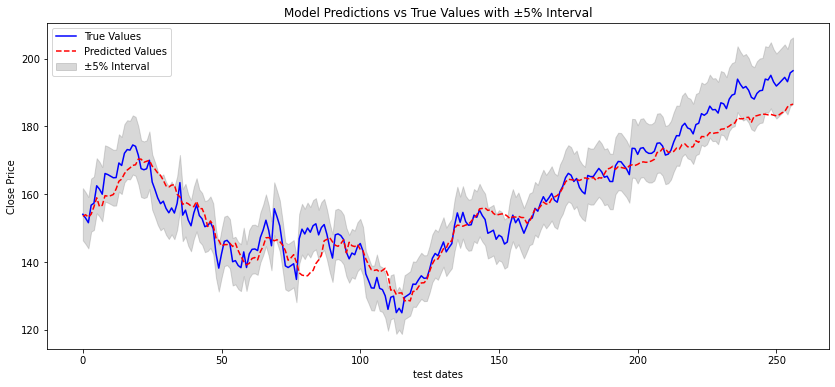

In [128]:
# Pull the summary of teh best model
best_model13.build(input_shape=(None, 28, 28))
best_model13.summary()

# Predict the x_test with best model
predicted_values = best_model13.predict(x_test_sc)

# inverse transforming to orginal values
y_test_original = scaler_y.inverse_transform(y_test_sc.reshape(-1,1))
predicted_values_orginal = scaler_y.inverse_transform(predicted_values.reshape(-1,1))

#Performance Metrics 1:
# Calculate Mean Absolute Error, Mean Squared Error,and MAPE
mae = mean_absolute_error(y_test_sc, predicted_values)
mse = mean_squared_error(y_test_sc, predicted_values)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_sc, predicted_values)
print(f"-------------------performance metrics 1-----------------------------")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print(f"-------------------performance metrics 2-----------------------------")
#performance metrics 2: Confidence Interval
risk_level = 0.05
y_test_original = np.array(y_test_original).ravel()

# Calculate the 5% bounds around the true values
upper_bound = y_test_original * (1+risk_level)
lower_bound = y_test_original * (1-risk_level)

predicted_values_orginal = predicted_values_orginal.reshape(-1)

# Count how many predicted values fall within the ±5% interval
within_interval = np.sum((predicted_values_orginal >= lower_bound) & (predicted_values_orginal <= upper_bound))

# Calculate the percentage of predictions within the ±5% interval
percentage_within_interval = (within_interval / len(y_test_original)) * 100

predicted_values_greater_than_upper_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))
print(f'predicted_values greater than upper_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal <= upper_bound))}')

predicted_values_lesser_than_lower_bound = (len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))
print(f'predicted_values lesser than lower_bound: {(len(y_test_original)) - (np.sum(predicted_values_orginal >= lower_bound))}')

total_predictions = len(y_test_original)
print(f"No. of predicted values within the ±{(risk_level*100)}% interval: {within_interval:} / {len(y_test_original)}")
print(f"Percentage of predictions within the ±{(risk_level*100)}% interval: {percentage_within_interval:.2f}%")

# Plotting
plt.figure(figsize=(14, 6))

# Plot true values
plt.plot(y_test_original, label="True Values", color='blue')

# Plot predicted values
plt.plot(predicted_values_orginal, label="Predicted Values", color='red', linestyle='--')

# Shade the ±5% interval
plt.fill_between(range(len(y_test_original)), lower_bound, upper_bound, color='grey', alpha=0.3, label="±5% Interval")

plt.title("Model Predictions vs True Values with ±5% Interval")
plt.xlabel("test dates")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [129]:
#save output
outputs = {
        'Experiment_Name': f"Experiment_13",
        'Experiment Description': f"Dataset_D3 with hyp-parameter optimixed LSTM Model",
        'MAE': mae,
        'MSE': mse,
        'MAPE': mape,
        'Predicted > Upper Bound': predicted_values_greater_than_upper_bound,
        'Predicted < Lower Bound': predicted_values_lesser_than_lower_bound,
        'Within Interval': within_interval,
        'Total Predictions': total_predictions,
        'Percentage Within Interval': percentage_within_interval
    }
    
# Append results to output_df
output_df = output_df.append(outputs, ignore_index=True)  
output_df

C:\Users\deenu\AppData\Local\Temp\ipykernel_41276\634240608.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output_df = output_df.append(outputs, ignore_index=True)


,Experiment_Name,MAE,MSE,MAPE,Predicted > Upper Bound,Predicted < Lower Bound,Within Interval,Total Predictions,Percentage Within Interval,Experiment Description
0,Experiment_1,0.030005,0.001676,13.033583,19,45,193,257,75.097276,Dataset_A with RF regressor Model
1,Experiment_2,0.084426,0.009025,6.885775,0,169,88,257,34.241245,Dataset_A with LSTM Model
2,Experiment_3,0.044867,0.00257,5.356705,97,0,160,257,62.256809,Dataset_A with hyp-parameter optimixed LSTM Model
3,Experiment_4,0.290908,0.103972,24.784535,0,244,4,248,1.612903,Dataset_B with LSTM Model
4,Experiment_5,0.095507,0.012327,11.405097,109,77,62,248,25.0,Dataset_B with hyp-parameter optimixed LSTM Model
5,Experiment_6,0.412556,0.188241,35.823095,0,248,0,248,0.0,Dataset_C with LSTM Model
6,Experiment_7,0.034891,0.001557,3.988539,18,34,196,248,79.032258,Dataset_C with hyp-parameter optimixed LSTM Model
7,Experiment_8,0.085676,0.011173,6.86701,19,125,113,257,43.968872,Dataset_D1 with LSTM Model
8,Experiment_9,0.030614,0.001433,3.436529,1,49,207,257,80.544747,Dataset_D1 with hyp-parameter optimixed LSTM M...
9,Experiment_10,0.114423,0.018159,9.189428,7,177,73,257,28.404669,Dataset_D2 with LSTM Model


In [136]:
output_df.to_csv('output_df_Stock price prediction.csv')

# !!! Sentiment vs closing price

# Dataset_D1 with non-news days filled with '0'

 0.0    1834
 1.0     372
-1.0     359
Name: Dominant_Sentiment, dtype: int64


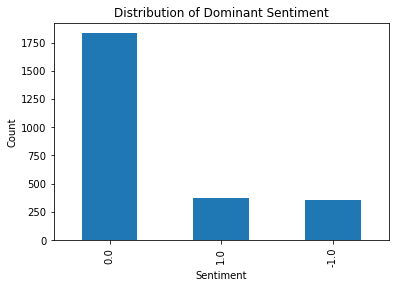

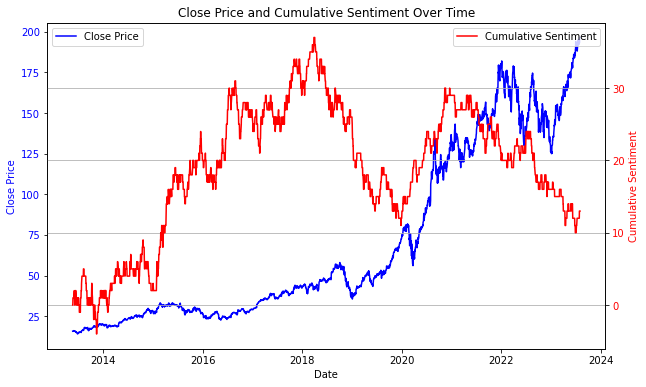

In [131]:
#pulling data using pickle
import pickle

with open("fn_senti_wv.pkl", "rb") as file:
    fn_senti_wv = pickle.load(file)
fn_senti_wv

apple_ds_d1 = Dataset_A.copy()

#filling non news days
tifn_merged_df_0 = apple_ds_d1.merge(fn_senti_wv, on='Date', how='outer')
tifn_merged_df_0['Dominant_Sentiment'].fillna(0, inplace=True)
tifn_merged_df_0.head()

#remove NaNs
rows_with_na7 = tifn_merged_df_0[tifn_merged_df_0.isna().any(axis=1)]
rows_with_na7
# Identify indices of rows with NaN values
indices_to_drop = rows_with_na7.index
# Drop these rows with NaN
tifn_merged_df_0 = tifn_merged_df_0.drop(indices_to_drop)
tifn_merged_df_0

senti_vs_closeprice = tifn_merged_df_0.copy()
senti_vs_closeprice = senti_vs_closeprice[['Date','Close','Dominant_Sentiment']]
senti_vs_closeprice['Cumulative_Sentiment'] = senti_vs_closeprice['Dominant_Sentiment'].cumsum()
senti_vs_closeprice

# Getting the distribution of the Dominant_Sentiment column
distribution = senti_vs_closeprice['Dominant_Sentiment'].value_counts()
print(distribution)

import matplotlib.pyplot as plt

distribution.plot(kind='bar')
plt.title('Distribution of Dominant Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plotting data
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting Close price
ax1.plot(senti_vs_closeprice['Date'], senti_vs_closeprice['Close'], color='b', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis for cumulative sentiment
ax2 = ax1.twinx()
ax2.plot(senti_vs_closeprice['Date'], senti_vs_closeprice['Cumulative_Sentiment'], color='r', label='Cumulative Sentiment')
ax2.set_ylabel('Cumulative Sentiment', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and grid
plt.title('Close Price and Cumulative Sentiment Over Time')
plt.grid(True)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Dataset_D2 with non-news days filled with '0'

 0.0    2095
-1.0     269
 1.0     201
Name: Dominant_Sentiment, dtype: int64


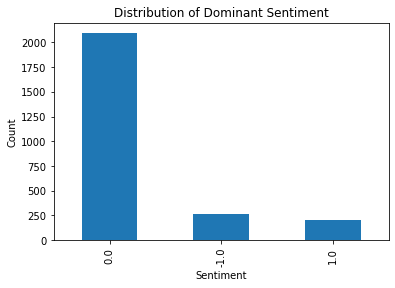

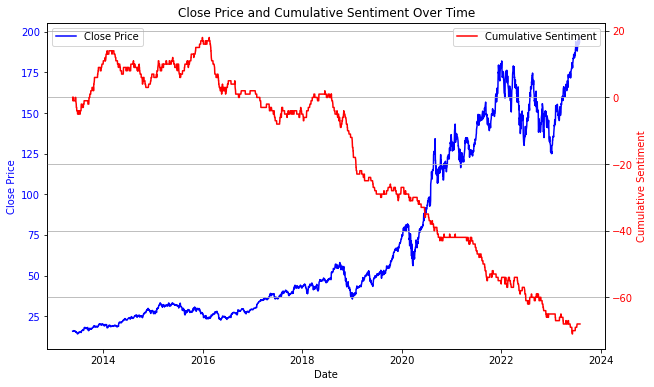

In [133]:
# Merge TI+FN (without FI)

#Load sentiment data from the sentiment analysis sheet
import pickle

with open("fn_senti_finbert.pkl", "rb") as file:
    fn_senti_finbert = pickle.load(file)
fn_senti_finbert

apple_ds_d2 = Dataset_A.copy()

#filling non news days 
tifn_fin_merged_df_0 = apple_ds_d2.merge(fn_senti_finbert, on='Date', how='outer')
tifn_fin_merged_df_0['Dominant_Sentiment'].fillna(0, inplace=True)

#remove NaNs
rows_with_na8 = tifn_fin_merged_df_0[tifn_fin_merged_df_0.isna().any(axis=1)]
rows_with_na8
# Identify indices of rows with NaN values
indices_to_drop = rows_with_na8.index
# Drop these rows with NaN
tifn_fin_merged_df_0 = tifn_fin_merged_df_0.drop(indices_to_drop)
tifn_fin_merged_df_0

senti_vs_closeprice = tifn_fin_merged_df_0.copy()
senti_vs_closeprice = senti_vs_closeprice[['Date','Close','Dominant_Sentiment']]
senti_vs_closeprice['Cumulative_Sentiment'] = senti_vs_closeprice['Dominant_Sentiment'].cumsum()
senti_vs_closeprice

# Getting the distribution of the Dominant_Sentiment column
distribution = senti_vs_closeprice['Dominant_Sentiment'].value_counts()
print(distribution)

import matplotlib.pyplot as plt

distribution.plot(kind='bar')
plt.title('Distribution of Dominant Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plotting data
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting Close price
ax1.plot(senti_vs_closeprice['Date'], senti_vs_closeprice['Close'], color='b', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis for cumulative sentiment
ax2 = ax1.twinx()
ax2.plot(senti_vs_closeprice['Date'], senti_vs_closeprice['Cumulative_Sentiment'], color='r', label='Cumulative Sentiment')
ax2.set_ylabel('Cumulative Sentiment', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and grid
plt.title('Close Price and Cumulative Sentiment Over Time')
plt.grid(True)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

# Dataset_D3 with non-news days filled with '0'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2565 entries, 97 to 2661
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2565 non-null   datetime64[ns]
 1   Open         2565 non-null   float64       
 2   High         2565 non-null   float64       
 3   Low          2565 non-null   float64       
 4   Close        2565 non-null   float64       
 5   Adj Close    2565 non-null   float64       
 6   Volume       2565 non-null   int64         
 7   MACD         2565 non-null   float64       
 8   MACD_SIGNAL  2565 non-null   float64       
 9   MACD_HIST    2565 non-null   float64       
 10  ATR          2565 non-null   float64       
 11  RSI          2565 non-null   float64       
 12  OBV          2565 non-null   float64       
 13  NATR         2565 non-null   float64       
 14  ADXR         2565 non-null   float64       
 15  TRIX         2565 non-null   float64       
 16  ADOSC

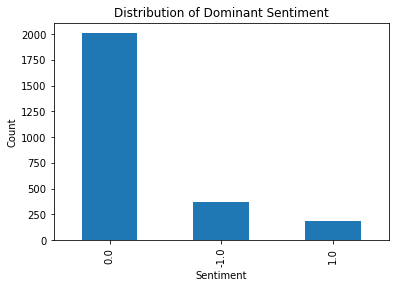

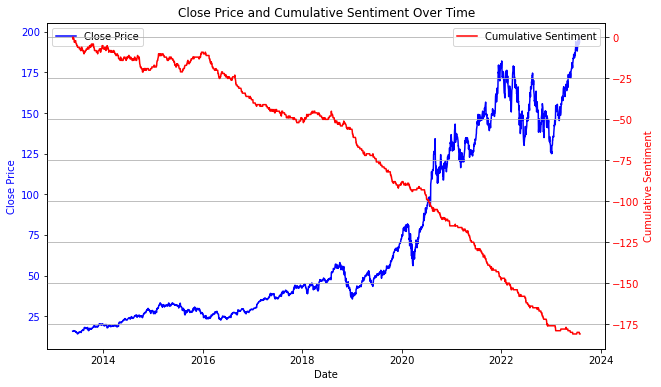

In [135]:
# Merge TI+FN (without FI)

#Load sentiment data from the sentiment analysis sheet
import pickle

with open("cp_vs_senti_grouped_sum.pkl", "rb") as file:
    cp_vs_senti_grouped_sum = pickle.load(file)
fn_senti_chatGPT

apple_ds_d3 = Dataset_A.copy()
apple_ds_d3.info()

tifn_chatGPT_merged_df = apple_ds_d3.merge(fn_senti_chatGPT, on='Date', how='outer')
tifn_chatGPT_merged_df['Dominant_prediction'].fillna(0, inplace=True)
tifn_chatGPT_merged_df.head(60)

rows_with_na8 = tifn_chatGPT_merged_df[tifn_chatGPT_merged_df.isna().any(axis=1)]
rows_with_na8

# Identify indices of rows with NaN values
indices_to_drop = rows_with_na8.index

# Drop these rows with NaN
tifn_chatGPT_merged_df = tifn_chatGPT_merged_df.drop(indices_to_drop)
tifn_chatGPT_merged_df


senti_fin_vs_closeprice = tifn_chatGPT_merged_df.copy()
senti_fin_vs_closeprice = senti_fin_vs_closeprice[['Date','Close','Dominant_prediction']]
#senti_fin_vs_closeprice['Dominant_Sentiment'] = senti_fin_vs_closeprice['Dominant_Sentiment'].replace({0: -1, 1: 0, 2: 1})
senti_fin_vs_closeprice['Cumulative_prediction'] = senti_fin_vs_closeprice['Dominant_prediction'].cumsum()
senti_fin_vs_closeprice

# Getting the distribution of the Dominant_Sentiment column
distribution1 = senti_fin_vs_closeprice['Dominant_prediction'].value_counts()
print(distribution1)

import matplotlib.pyplot as plt

distribution1.plot(kind='bar')
plt.title('Distribution of Dominant Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plotting data
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting Close price
ax1.plot(senti_fin_vs_closeprice['Date'], senti_fin_vs_closeprice['Close'], color='b', label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Creating a secondary y-axis for cumulative sentiment
ax2 = ax1.twinx()
ax2.plot(senti_fin_vs_closeprice['Date'], senti_fin_vs_closeprice['Cumulative_prediction'], color='r', label='Cumulative Sentiment')
ax2.set_ylabel('Cumulative Sentiment', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and grid
plt.title('Close Price and Cumulative Sentiment Over Time')
plt.grid(True)

# Legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()